In [1]:
from collections import defaultdict
import logging
from typing import cast, Dict, List, Tuple, Union, Callable
from typing_extensions import get_args, Literal
import sys
import os
import numpy as np
import random 
import seaborn as sns
from PIL import Image
import re

import torch
import torch.nn as nn
import torch.nn.functional as F

import yaml
import argparse
import pandas as pd
from tqdm.notebook import tqdm
from functools import partial

from torch.utils.data import DataLoader, TensorDataset

sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments/utils')
sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments')

from aheads import create_repeats_dataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
from transformers import BertConfig, BertForMaskedLM, AdamW

import matplotlib.style as style
style.use('ggplot')

/users/sanand14/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /oscar/home/sanand14/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from utils.toy_utils import bin_train_loop, create_dataloaders_bin, Probe, POSVocabGenerator
from dataclasses import dataclass, field

In [3]:
from toy_model import TrainingPipeline

In [11]:
vocab_size = 1000
num_random = 100
epochs=1
batch_size = 10
dataset_size = 10000
a = 1.0001
## SETTING UP PARAMETERS
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## SETTING UP TASK
dset_gen = POSVocabGenerator()
dset_gen.parameterize_pos_vocab(vocab_size, num_random, prop_amb=0.10, a=a)

## SETTING UP MODEL
config = BertConfig(
    vocab_size=dset_gen.get_vocab_tokens(), ## args.vocab_size+3 if have null token
    hidden_size=16, # 128  
    num_hidden_layers=1, # 8
    num_attention_heads=1, # 8
    intermediate_size=32 # 512
)
toy_bert_model = BertForMaskedLM(config).to(device)
optimizer = torch.optim.AdamW(toy_bert_model.parameters(), lr=5e-5) 
step_eval = list(range(0, 1000, 20)) + list(range(1000, 30000, 100))
max_num_steps = dataset_size *  epochs/batch_size
print('Max number of steps is ', max_num_steps, flush=True)
pipeline = TrainingPipeline(
    model=toy_bert_model,
    vocab_gen=dset_gen,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    train_dataloader=None, ## set to none so will automatically set up
    test_dataloader=None, ## set to none so will automatically set up
    device=device,
    batch_size=batch_size,
    epochs=epochs,
    num_train=dataset_size,
    num_val=10_000,
    step_eval=step_eval,
    name=None, ## does not save model during training
    pca=['val', 'tail', 'random'],
    hist={},
    probe_results={},
    sample_func='zipfian')

[12, 18, 22, 26, 30, 50, 60, 79, 84, 94, 120, 129, 130, 132, 133, 149, 151, 159, 170, 172, 221, 223, 227, 239, 252, 254, 267, 281, 291, 295, 314, 322, 325, 327, 335, 359, 370, 371, 380, 391, 401, 405, 406, 410, 442, 450, 454, 457, 482, 489, 506, 517, 528, 538, 547, 553, 571, 579, 589, 590, 615, 617, 626, 637, 638, 656, 687, 688, 692, 695, 700, 706, 727, 732, 746, 760, 761, 775, 789, 798, 810, 839, 849, 852, 860, 870, 874, 883, 889, 894, 905, 906, 907, 917, 937, 942, 945, 955, 959, 981]
Max number of steps is  1000.0


In [19]:
pipeline.train_dataloader, pipeline.test_dataloader = pipeline._prepare_dataloaders()

DS [[1034, 1000, 1059, 1059, 1001, 1001, 1001], [1034, 1000, 1059, 1034, 1001, 1001, 1001]]
LS [[-100, -100, -100, -100, 1059, 1059, 1059], [-100, -100, -100, -100, 1059, 1034, 1034]]


In [20]:
pipeline.test_dataloader['']

{'val': <torch.utils.data.dataloader.DataLoader at 0x7fbc0534d220>,
 'tail': <torch.utils.data.dataloader.DataLoader at 0x7fbc056165b0>,
 'switch': <torch.utils.data.dataloader.DataLoader at 0x7fbc05616610>,
 'tail_switch': <torch.utils.data.dataloader.DataLoader at 0x7fbc05616490>,
 'holdout': <torch.utils.data.dataloader.DataLoader at 0x7fbc0531ad00>,
 'holdout_switch': <torch.utils.data.dataloader.DataLoader at 0x7fbc0531a970>}

In [5]:
prop_amb_all=0.0
tail_end=False
switch=False
random_v=False
holdout_once=True
holdout=False
amb_only=False
non_amb_only=False
device=None

In [6]:
dset_gen.special_token_dict_pos

{'cop': 100, 'mask': 101}

In [7]:
dataset = []
labels = []
holdout_noun_set = dset_gen.random_nouns.copy()
holdout_adj_set = dset_gen.random_adjs.copy()

In [40]:
def tmp_func_h(type):
    if len(holdout_noun_set) == 0 and len(holdout_adj_set) == 0:
        return None, False
    if type == 'noun':
        token = random.choice(holdout_noun_set) if len(holdout_noun_set) > 0 else random.choice(dset_gen.random_nouns)
        holdout_noun_set.remove(token)
    else:
        token = random.choice(holdout_adj_set) if len(holdout_adj_set) > 0 else random.choice(dset_gen.random_adjs)
        holdout_adj_set.remove(token)
    
    if len(holdout_noun_set) == 0 and len(holdout_adj_set) == 0:
        return token, False
    return token, True

sample_func_upd = tmp_func_h

In [41]:
still_tokens_left = True

while still_tokens_left:
    rand_val = random.random()
    adj, _ =  sample_func_upd('adj')
    noun, still_tokens_left = sample_func_upd('noun')
    seq_adj = [dset_gen.special_token_dict_pos['cop'], adj, noun] if rand_val < 0.50 else [noun, dset_gen.special_token_dict_pos['cop'], adj]
    seq_noun = seq_adj.copy()
    
    seq_adj.extend([adj, adj, adj, adj])
    seq_noun.extend([noun, adj, noun, noun])
    label_seq_adj = seq_adj.copy()
    label_seq_noun = seq_noun.copy()
    print(seq_adj, seq_noun)
    for i in range(len(seq_adj)):
        if i >= len(seq_adj) - 3:
            seq_adj[i] = dset_gen.special_token_dict_pos['mask']
            seq_noun[i] = dset_gen.special_token_dict_pos['mask']
        else:
            label_seq_adj[i] = -100
            label_seq_noun[i] = -100
    
    dataset.append(seq_adj)
    labels.append(label_seq_adj)
    dataset.append(seq_noun)
    labels.append(label_seq_noun)

[100, 115, 187, 115, 115, 115, 115] [100, 115, 187, 187, 115, 187, 187]
[173, 100, 142, 142, 142, 142, 142] [173, 100, 142, 173, 142, 173, 173]
[192, 100, 137, 137, 137, 137, 137] [192, 100, 137, 192, 137, 192, 192]
[100, 133, 200, 133, 133, 133, 133] [100, 133, 200, 200, 133, 200, 200]
[100, 119, 196, 119, 119, 119, 119] [100, 119, 196, 196, 119, 196, 196]
[100, 113, 163, 113, 113, 113, 113] [100, 113, 163, 163, 113, 163, 163]
[153, 100, 122, 122, 122, 122, 122] [153, 100, 122, 153, 122, 153, 153]
[167, 100, 102, 102, 102, 102, 102] [167, 100, 102, 167, 102, 167, 167]
[100, 145, 169, 145, 145, 145, 145] [100, 145, 169, 169, 145, 169, 169]
[100, 114, 191, 114, 114, 114, 114] [100, 114, 191, 191, 114, 191, 191]
[100, 109, 158, 109, 109, 109, 109] [100, 109, 158, 158, 109, 158, 158]
[100, 144, 189, 144, 144, 144, 144] [100, 144, 189, 189, 144, 189, 189]
[100, 147, 194, 147, 147, 147, 147] [100, 147, 194, 194, 147, 194, 194]
[168, 100, 107, 107, 107, 107, 107] [168, 100, 107, 168, 107, 16

In [24]:
optimizer.state_dict()['param_groups'][0]['weight_decay']

0.01

In [5]:
sample_func = lambda type: pipeline.vocab_gen.zipfian(type, a=pipeline.a) if pipeline.sample_func == 'zipfian' else lambda type: pipeline.vocab_gen.uniform(type)

In [6]:
prop_amb=0.0
tail_end=False
switch=False
random_v=True
device=None

dataset = []
labels = []

def get_sample_func_upd(sample_func):
    ## random embeddings
    if random_v:
        if len(pipeline.vocab_gen.random_tokens) == 0:
            raise ValueError('No random tokens found')
        return lambda type: random.choice(dset_gen.random_tokens)
    ## switch and tail
    if switch and tail_end:
        return lambda type: pipeline.vocab_gen.tail_end_z('noun') if type == 'adj' else pipeline.vocab_gen.tail_end_z('adj')
    ## just switch 
    if switch:
        return lambda type: sample_func('noun') if type == 'adj' else sample_func('adj')
    ## just tail end of distribution (10% tokens by number)
    if tail_end:
        return pipeline.vocab_gen.tail_end_z
    ## proportion ambiguous (used during training)
    if prop_amb > 0.0:
        def tmp_func(type):
            if random.random() > prop_amb:
                return sample_func(type)
            else:
                return sample_func('noun') if type == 'adj' else sample_func('adj')
        return tmp_func            
    return sample_func

sample_func_upd = get_sample_func_upd(sample_func)

In [7]:
inputs_v, labels_v = pipeline.vocab_gen.create_dataset_task_pos(pipeline.num_val, sample_func=sample_func, device=pipeline.device, random_v=True)

In [8]:
toy_bert_model.config.tie_word_embeddings

True

In [22]:
from kneed.knee_locator import KneeLocator

def first_point_x_p_top(p=0.05):
    pass

    
def get_pushdown(df_name, skip=2, sep=','):
    df = pd.read_csv(df_name, sep=sep)
    layer_knees = {}
    min_knee, max_knee, sum_diffs = 100000, 0, 0

    if 'Layer' in df.columns:
        df['Layer'] = df['Layer'].apply(lambda x: int(x.split(".")[-1]) + 1 if "." in x else 0)
        df.index = df['Layer']
        df.drop('Layer', axis=1, inplace=True)
    elif 'Unnamed: 0' in df.columns:
        df.index = df['Unnamed: 0']
        df.drop('Unnamed: 0', axis=1, inplace=True)
    df = df.sort_index()
    
    ax = plt.subplot()
    x = [int(v) for v in df.columns.tolist()][skip:]
    for idx in df.index:
        y = df.iloc[idx][skip:]
        # y = y[::-1]
        y = y.rolling(window=8, min_periods=1).mean()
        # y_smooth = y_smooth[::-1]
        # spl = UnivariateSpline(x, y_smooth, k=3)
        # y_smooth = spl(y_smooth)
        # print(len(x), len(y_smooth))
        ax.plot(x, y, label=idx)
        kl = KneeLocator(x, y)#, interp_method='polynomial', polynomial_degree=7)
        # kl.plot_knee()
        layer_knees[idx] = kl.knee
        print(max(kl.all_knees))
        # if layer_knees[idx] < min_knee:
        #     min_knee = layer_knees[idx]
        # if layer_knees[idx] > max_knee:
        #     max_knee = layer_knees[idx]

    ax.legend()
    for idx in range(len(layer_knees)-1, 0, -1):
        # print(layer_knees, idx)
        sum_diffs += layer_knees[idx] - layer_knees[idx-1]

    plt.figure()
    sns.heatmap(df[::-1], annot=False, cbar_kws={'orientation': 'horizontal'})
    return min_knee, max_knee, sum_diffs

200
160
300
200
200
200
200
180
160
160
160
160
160


(100000, 0, -40)

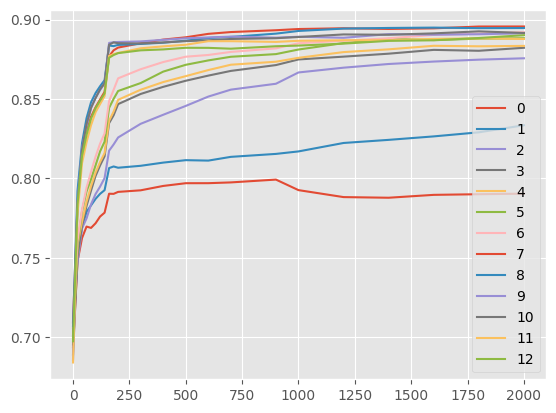

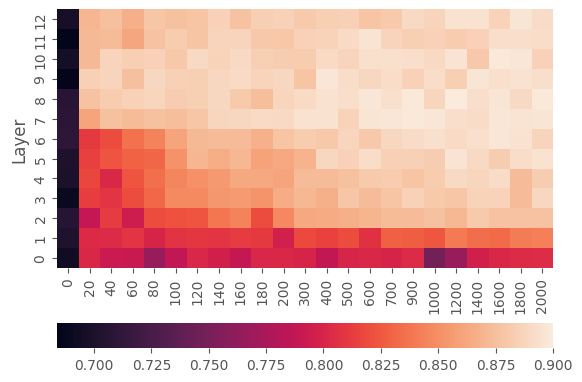

In [23]:
# df = pd.read_csv('../../outputs/en_ewt-ud/seed_0/fpos/Val_Acc.csv', sep='\t')
get_pushdown('../../outputs/en_ewt-ud/seed_0/fpos/Val_Acc.csv', skip=0, sep='\t')

In [447]:
def dir_deriv(df_name):
    df = pd.read_csv(df_name)
    gradient_y, gradient_x = np.gradient(df.values)
    x, y = np.array(range(len(df.columns))), np.array(list(df.index)) #[int(v) for v in df.columns]
    X, Y = np.meshgrid(x, y)
    
    fig, ax = plt.subplots()    
    plt.quiver(X, Y, gradient_x, gradient_y, color='red')
    plt.title('Vector Field of Gradients')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()
    dx, dy = 1 / np.sqrt(2), -1 / np.sqrt(2)
    directional_derivative = gradient_x * dx + gradient_y * dy
    return np.mean(directional_derivative)

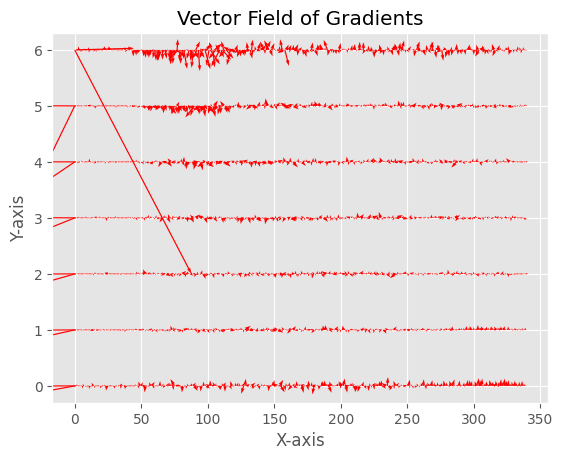

-0.004516904530557451

In [448]:
dir_deriv('../../outputs/toy_model/zipfr-amb_0.0-vs_20000-a_1.2/pos_probing_results_tail.csv')

In [449]:
get_pushdown('../../outputs/toy_model/zipfr-amb_0.0-vs_20000-a_1.2/pos_probing_results_tail.csv', skip=0)

KeyError: 'Layer'

In [428]:
np.mean(directional_derivative)

0.013089763537523376

In [262]:
df_tail = pd.read_csv(f'../../outputs/toy_model/zipfr-amb_0.10-vs_20000-a_1.2/pos_probing_results_tail.csv')

In [179]:
df_tail.index = df_tail['Unnamed: 0']
df_tail.drop('Unnamed: 0', axis=1, inplace=True)

<Axes: ylabel='Unnamed: 0'>

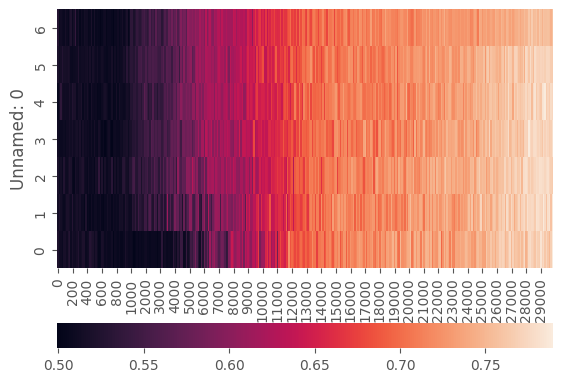

In [180]:
sns.heatmap(df_tail, annot=False, cbar_kws={'orientation': 'horizontal'})

In [181]:
df_tail = df_tail[::-1]

In [182]:
kl = KneeLocator([int(v) for v in df_tail.columns.tolist()][10:], df_tail.iloc[3][10:], interp_method='polynomial', polynomial_degree=2)

0 {29800}
1 {29800}
2 {25800}
3 {25800}
4 {25800}
5 {25800}
6 {25800}


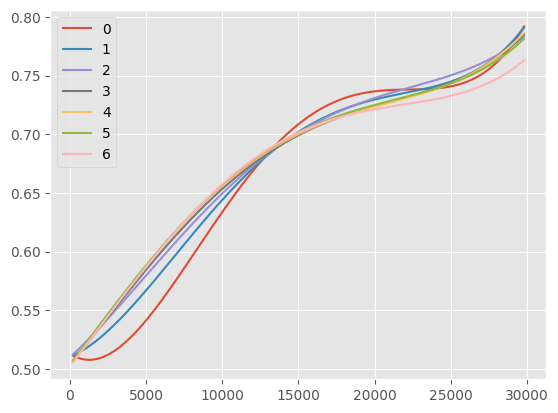

In [217]:
vals = set()
ax = plt.subplot()
for i in range(len(df_tail)):
    # df_tail.iloc[i].plot(ax=ax, label=i)
    x = [int(v) for v in df_tail.columns.tolist()][10:]
    y = df_tail.iloc[i][10:]
    spl = UnivariateSpline(x, y, k=4)
    y_smooth = spl(x)
    
    kl = KneeLocator(x, y_smooth, interp_method='polynomial', polynomial_degree=3, curve='convex').all_knees
    ax.plot(x, y_smooth, label=i)
    vals.update(kl)
    print(i, kl)
ax.legend()

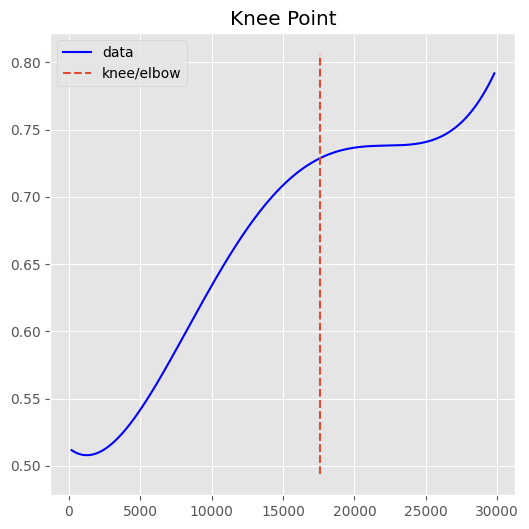

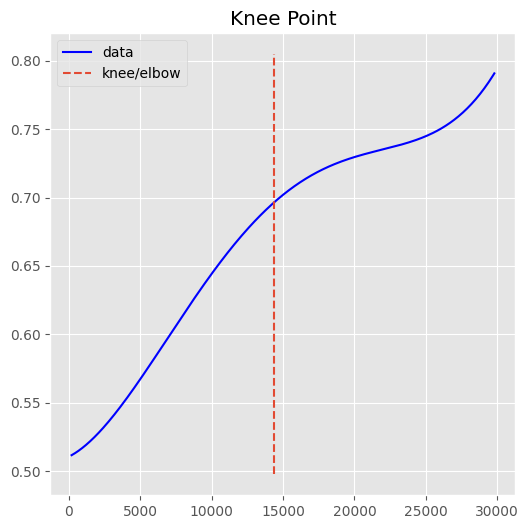

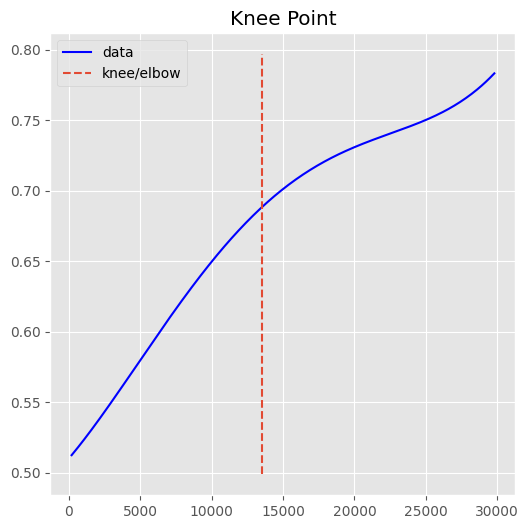

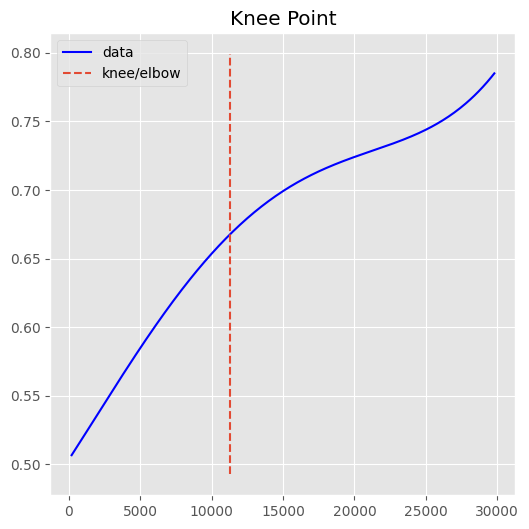

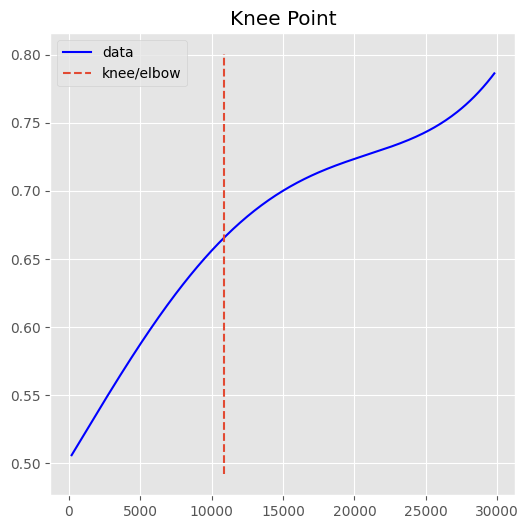

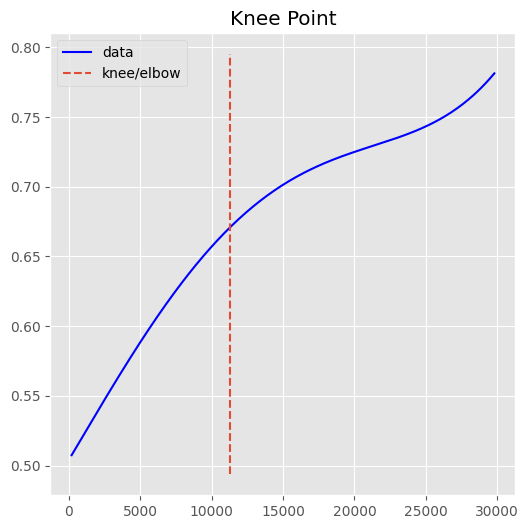

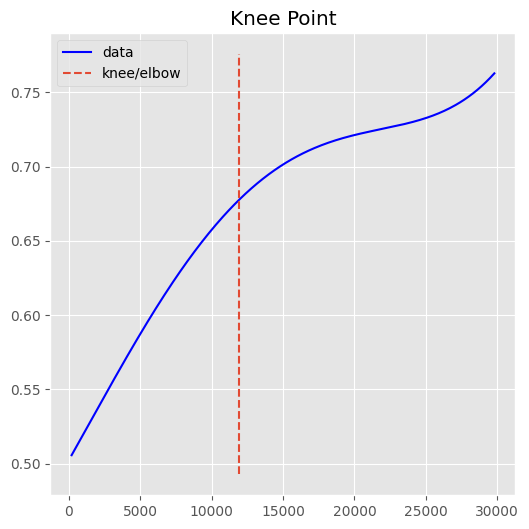

In [214]:
from scipy.interpolate import UnivariateSpline, BivariateSpline

for i in range(len(df_tail)):
    df_tail.iloc[i].plot(ax=ax, label=i)
    x = [int(v) for v in df_tail.columns.tolist()][10:]
    y = df_tail.iloc[i][10:]
    spl = UnivariateSpline(x, y, k=4)
    y_smooth = spl(x)

    kl = KneeLocator(x, y_smooth, interp_method='polynomial', polynomial_degree=3)
    kl.plot_knee()

In [220]:
cols = [val for val in df_tail.columns if int(val) >= 8000 and int(val) <= 30000]

<Axes: ylabel='Unnamed: 0'>

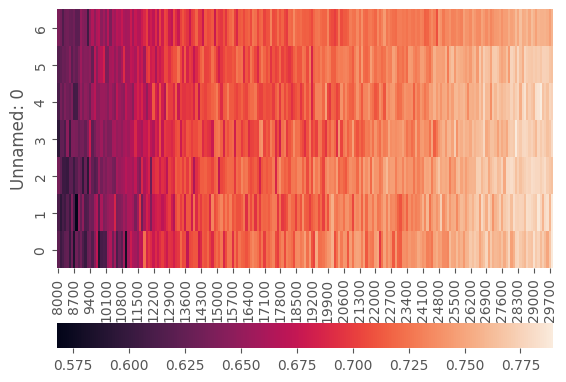

In [221]:
sns.heatmap(df_tail[cols][::-1], annot=False, cbar_kws={'orientation': 'horizontal'})

<Axes: >

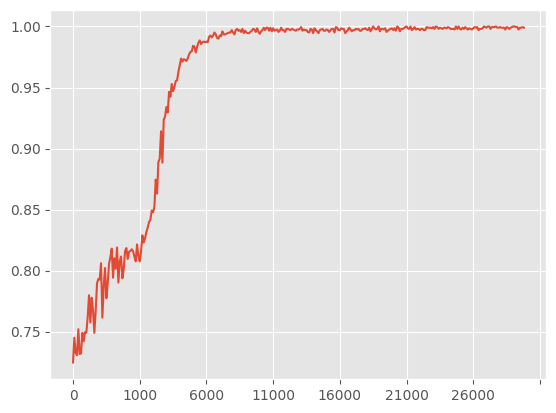

In [70]:
df_tail = df_tail[::-1]
df_tail.iloc[4].plot()

In [3]:
import matplotlib.gridspec as gridspec

def timing_plot(prefix="zipf", vs=1000, a=1.0001, tail=False, include_switch=True, output_file='../../figures/toy_model/all/zipf_vs=1000_a=1.0001.png'):
    if include_switch:
        df_sw = pd.read_csv(f'../../outputs/toy_model/{prefix}-layer_6-vs_{vs}-a_{a}/hist_switch.csv')
        acc_sw = df_sw[df_sw['Unnamed: 0'] == 'acc'].drop('Unnamed: 0', axis=1)
    
    df = pd.read_csv(f'../../outputs/toy_model/{prefix}-layer_6-vs_{vs}-a_{a}/hist{"_tail" if tail else ""}.csv')
    acc = df[df['Unnamed: 0'] == 'acc'].drop('Unnamed: 0', axis=1)
    
    fig = plt.figure(figsize=(8, 12))
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
    
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    
    acc.iloc[0].plot(ax=ax1)
    l1 = 'Tail' if tail else 'Val'
    if include_switch:
        acc_sw.iloc[0].plot(ax=ax1)
        ax1.legend([l1, 'Switch'])
        
    ax1.set_title("Masked Token Accuracy")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Accuracy")
    
    df = pd.read_csv(f'../../outputs/toy_model/{prefix}-layer_6-vs_{vs}-a_{a}/pos_probing{"_tail" if tail else ""}_results.csv')
    df.index = df['Unnamed: 0'] 
    df = df.drop('Unnamed: 0', axis=1)
    sns.heatmap(df, ax=ax2, annot=False, cbar_kws={'orientation': 'horizontal'})
    
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Layer")
    ax2.set_title(f"POS {'Tail ' if tail else ''}Probing")
    plt.show()
    plt.savefig(output_file)

In [4]:
def timing_plot_w_tail(prefix="zipf", vs=1000, a=1.0001, amb=0.0, include_switch=True, output_file='../../figures/toy_model/both/zipf_vs=1000_a=1.0001.png'):
    # if include_switch:
    if amb > 0:
        amb = f'{amb:0.2f}'
    df_sw = pd.read_csv(f'../../outputs/toy_model/{prefix}-amb_{amb}-vs_{vs}-a_{a}/hist_switch.csv')
    acc_sw = df_sw[df_sw['Unnamed: 0'] == 'acc'].drop('Unnamed: 0', axis=1)
    
    df = pd.read_csv(f'../../outputs/toy_model/{prefix}-amb_{amb}-vs_{vs}-a_{a}/hist_val.csv')
    acc = df[df['Unnamed: 0'] == 'acc'].drop('Unnamed: 0', axis=1)
    
    df_tail = pd.read_csv(f'../../outputs/toy_model/{prefix}-amb_{amb}-vs_{vs}-a_{a}/hist_tail.csv')
    acc_tail = df_tail[df_tail['Unnamed: 0'] == 'acc'].drop('Unnamed: 0', axis=1)

    df_sw_tail = pd.read_csv(f'../../outputs/toy_model/{prefix}-amb_{amb}-vs_{vs}-a_{a}/hist_tail_switch.csv')
    acc_sw_tail= df_sw_tail[df_sw_tail['Unnamed: 0'] == 'acc'].drop('Unnamed: 0', axis=1)
    
    fig = plt.figure(figsize=(16, 12))
    
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 3], width_ratios=[1, 1])
    
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2])
    ax4 = fig.add_subplot(gs[3], sharex=ax3)
    
    acc.iloc[0].plot(ax=ax1)
    if include_switch:
        acc_sw.iloc[0].plot(ax=ax1)
        ax1.legend(['Val', 'Switch'])
        
        
    ax1.set_title("Masked Token Accuracy")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Accuracy")

    acc_tail.iloc[0].plot(ax=ax2)
    if include_switch:
        acc_sw_tail.iloc[0].plot(ax=ax2)
        ax2.legend(['Tail', 'Tail Switch'])
        
    ax2.set_title("Masked Tail Token Accuracy")
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Accuracy")
    
    df = pd.read_csv(f'../../outputs/toy_model/{prefix}-amb_{amb}-vs_{vs}-a_{a}/pos_probing_results_val.csv')
    df.index = df['Unnamed: 0'] 
    df = df.drop('Unnamed: 0', axis=1)
    sns.heatmap(df, ax=ax3, annot=False, cbar_kws={'orientation': 'horizontal'})
    
    ax3.set_xlabel("Step")
    ax3.set_ylabel("Layer")
    ax3.set_title(f"POS Probing")
    
    df_tail = pd.read_csv(f'../../outputs/toy_model/{prefix}-amb_{amb}-vs_{vs}-a_{a}/pos_probing_results_tail.csv')
    df_tail.index = df_tail['Unnamed: 0'] 
    df_tail = df_tail.drop('Unnamed: 0', axis=1)
    sns.heatmap(df_tail, ax=ax4, annot=False, cbar_kws={'orientation': 'horizontal'})
    
    ax4.set_xlabel("Step")
    ax4.set_ylabel("Layer")
    ax4.set_title(f"POS Tail Probing")
    plt.tight_layout()

    plt.savefig(output_file)
    plt.show()
    

In [ ]:
timing_plot_w_tail(prefix="zipf", amb=0.0, vs=20000, a=1.2, include_switch=True, output_file='../../figures/toy_model/both/zipf_amb=0.0_vs=20000_a=1.2.png')

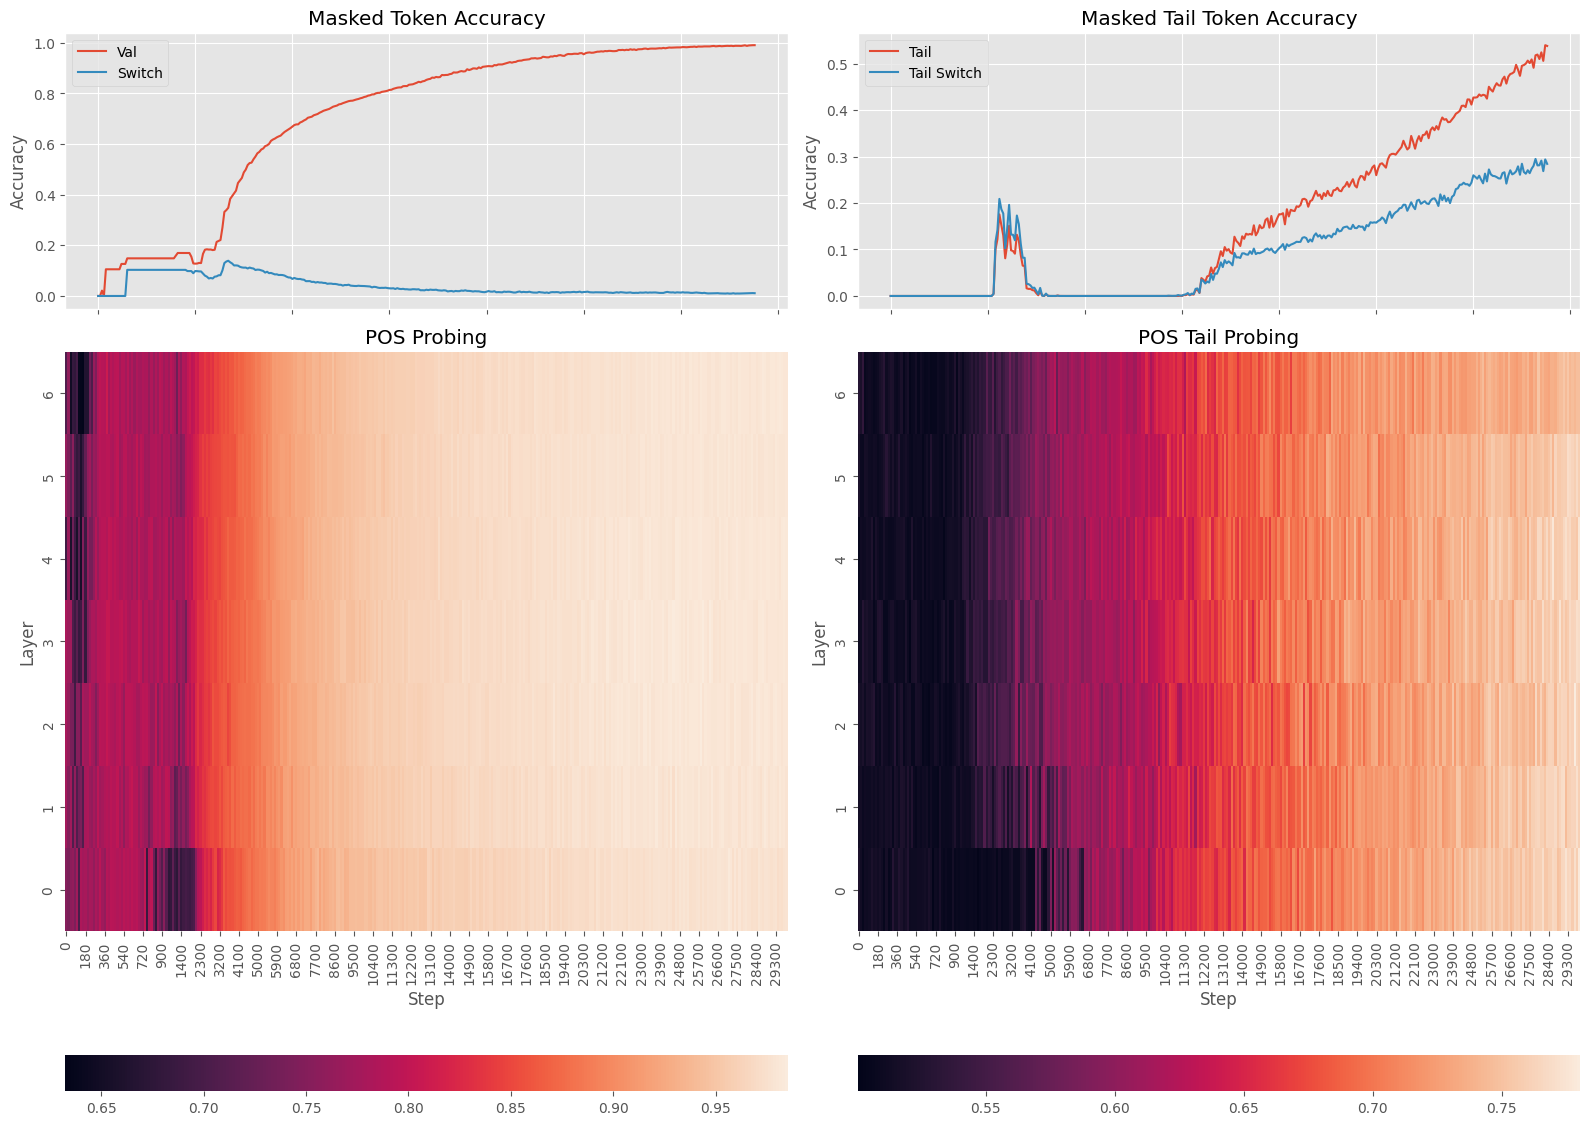

In [5]:
timing_plot_w_tail(prefix="zipf", amb=0.0, vs=20000, a=1.2, include_switch=True, output_file='../../figures/toy_model/both/zipf_amb=0.0_vs=20000_a=1.2.png')

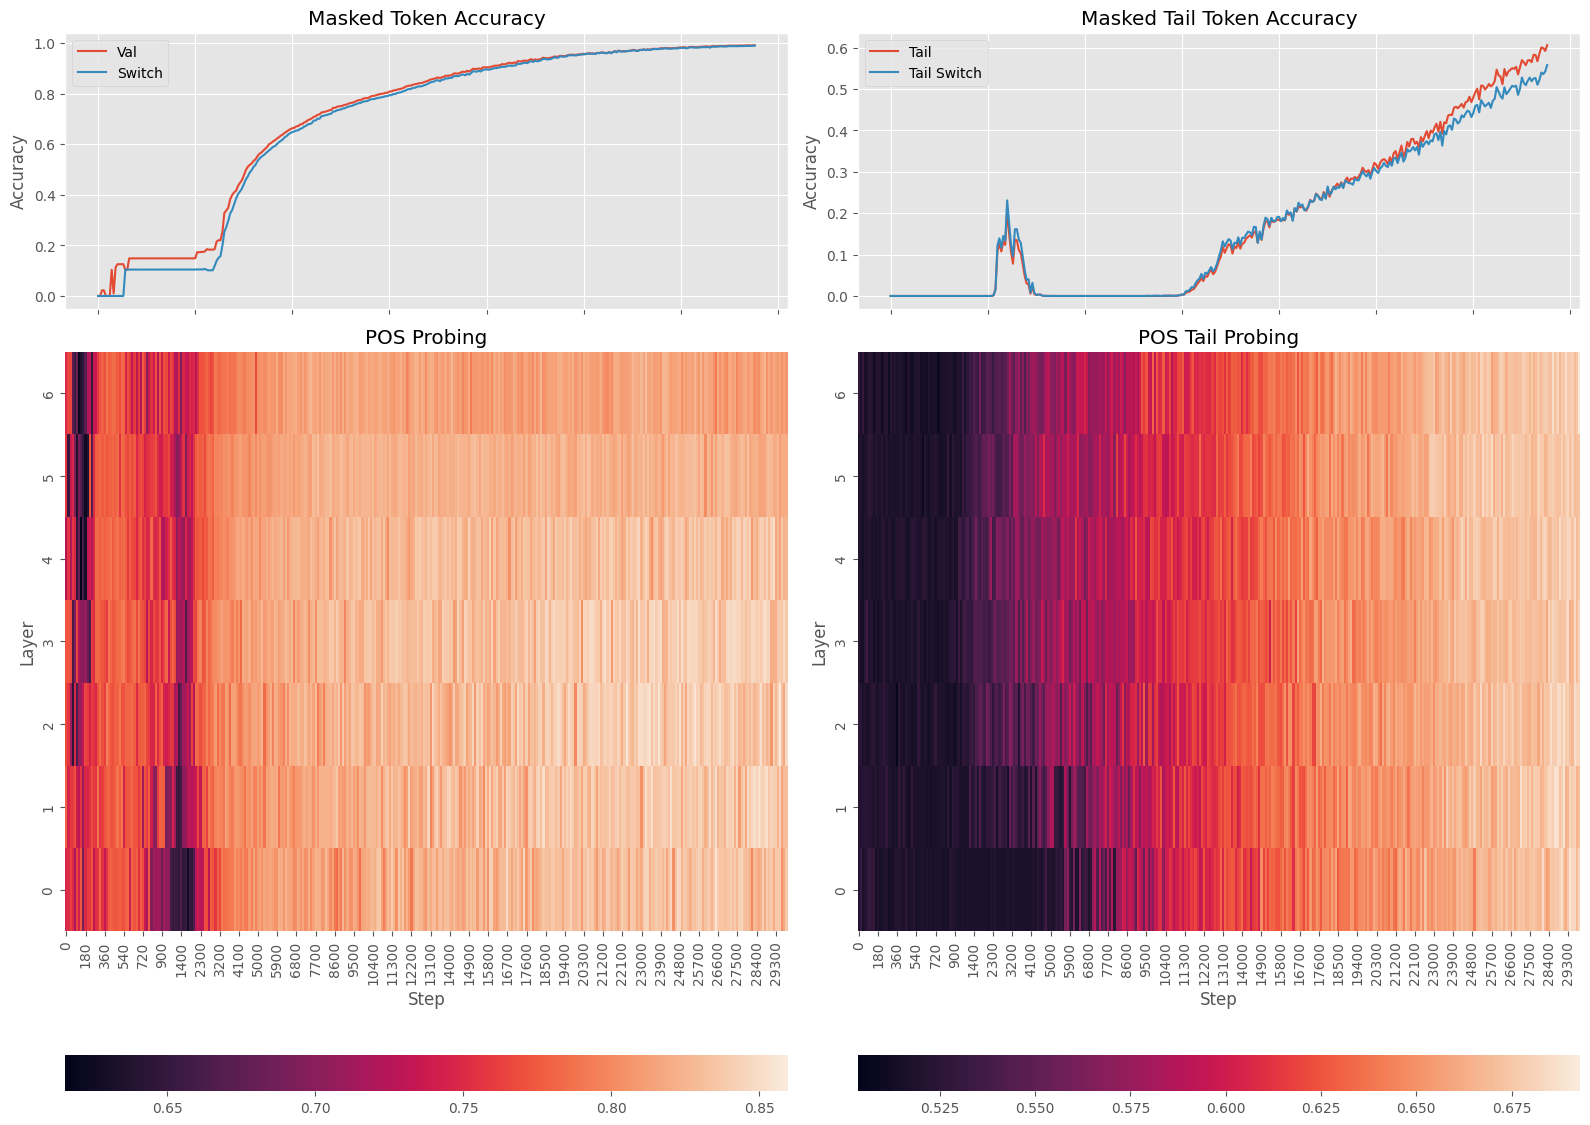

In [6]:
timing_plot_w_tail(prefix="zipf", amb=0.10, vs=20000, a=1.2, include_switch=True, output_file='../../figures/toy_model/both/zipf_amb=0.10_vs=20000_a=1.2.png')


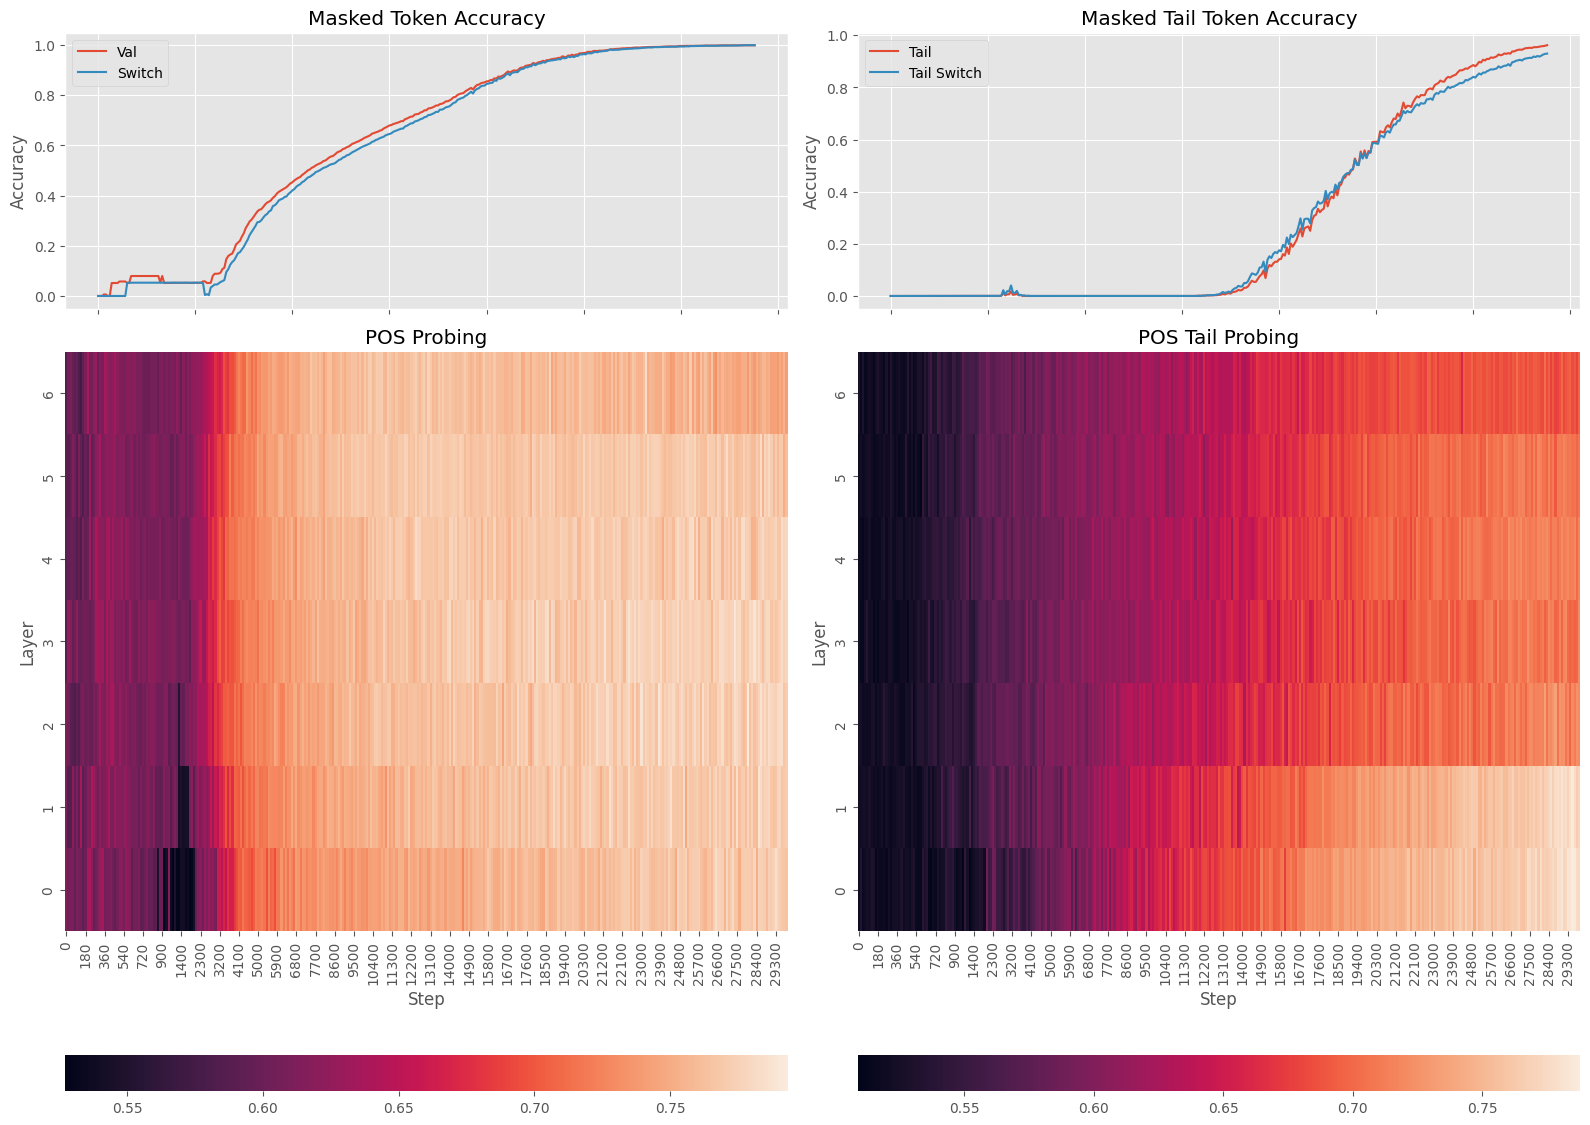

In [5]:
timing_plot_w_tail(prefix="zipf", amb=0.10, vs=20000, a=1.0001, include_switch=True, output_file='../../figures/toy_model/both/zipf_amb=0.10_vs=10000_a=1.0001.png')

## 

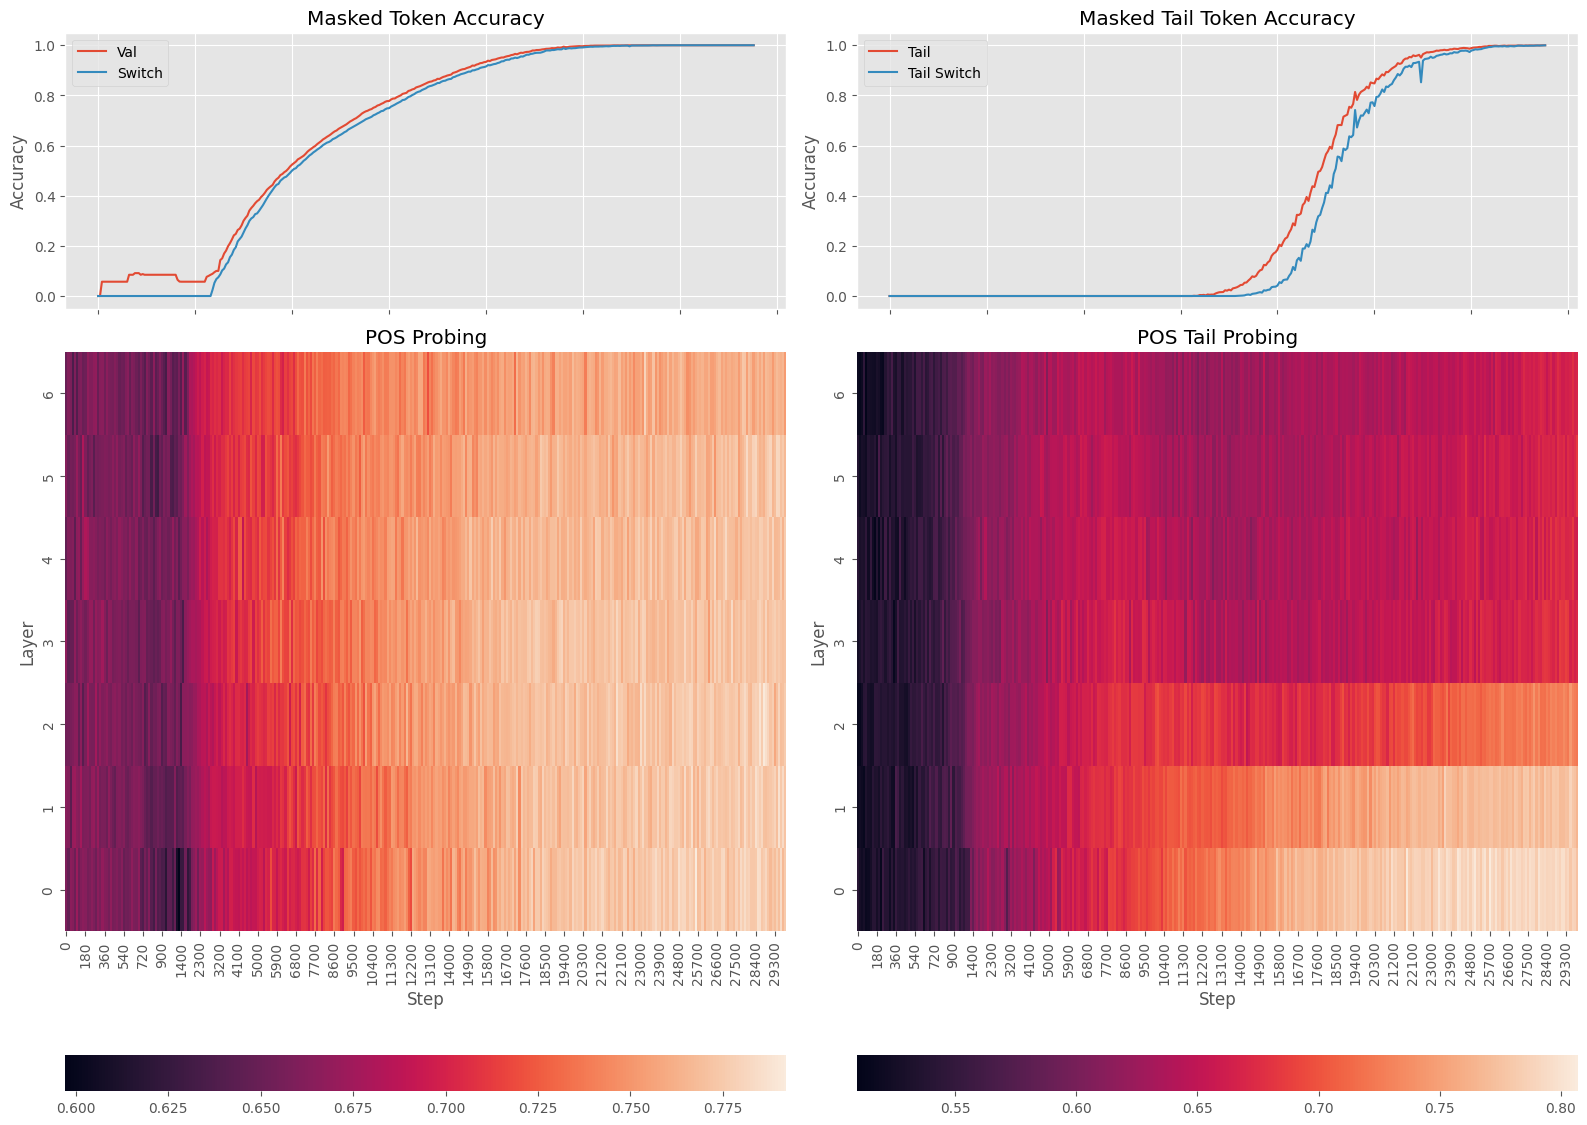

In [7]:
timing_plot_w_tail(prefix="zipf", amb=0.10, vs=10000, a=1.0001, include_switch=True, output_file='../../figures/toy_model/both/zipf_amb=0.10_vs=10000_a=1.0001.png')


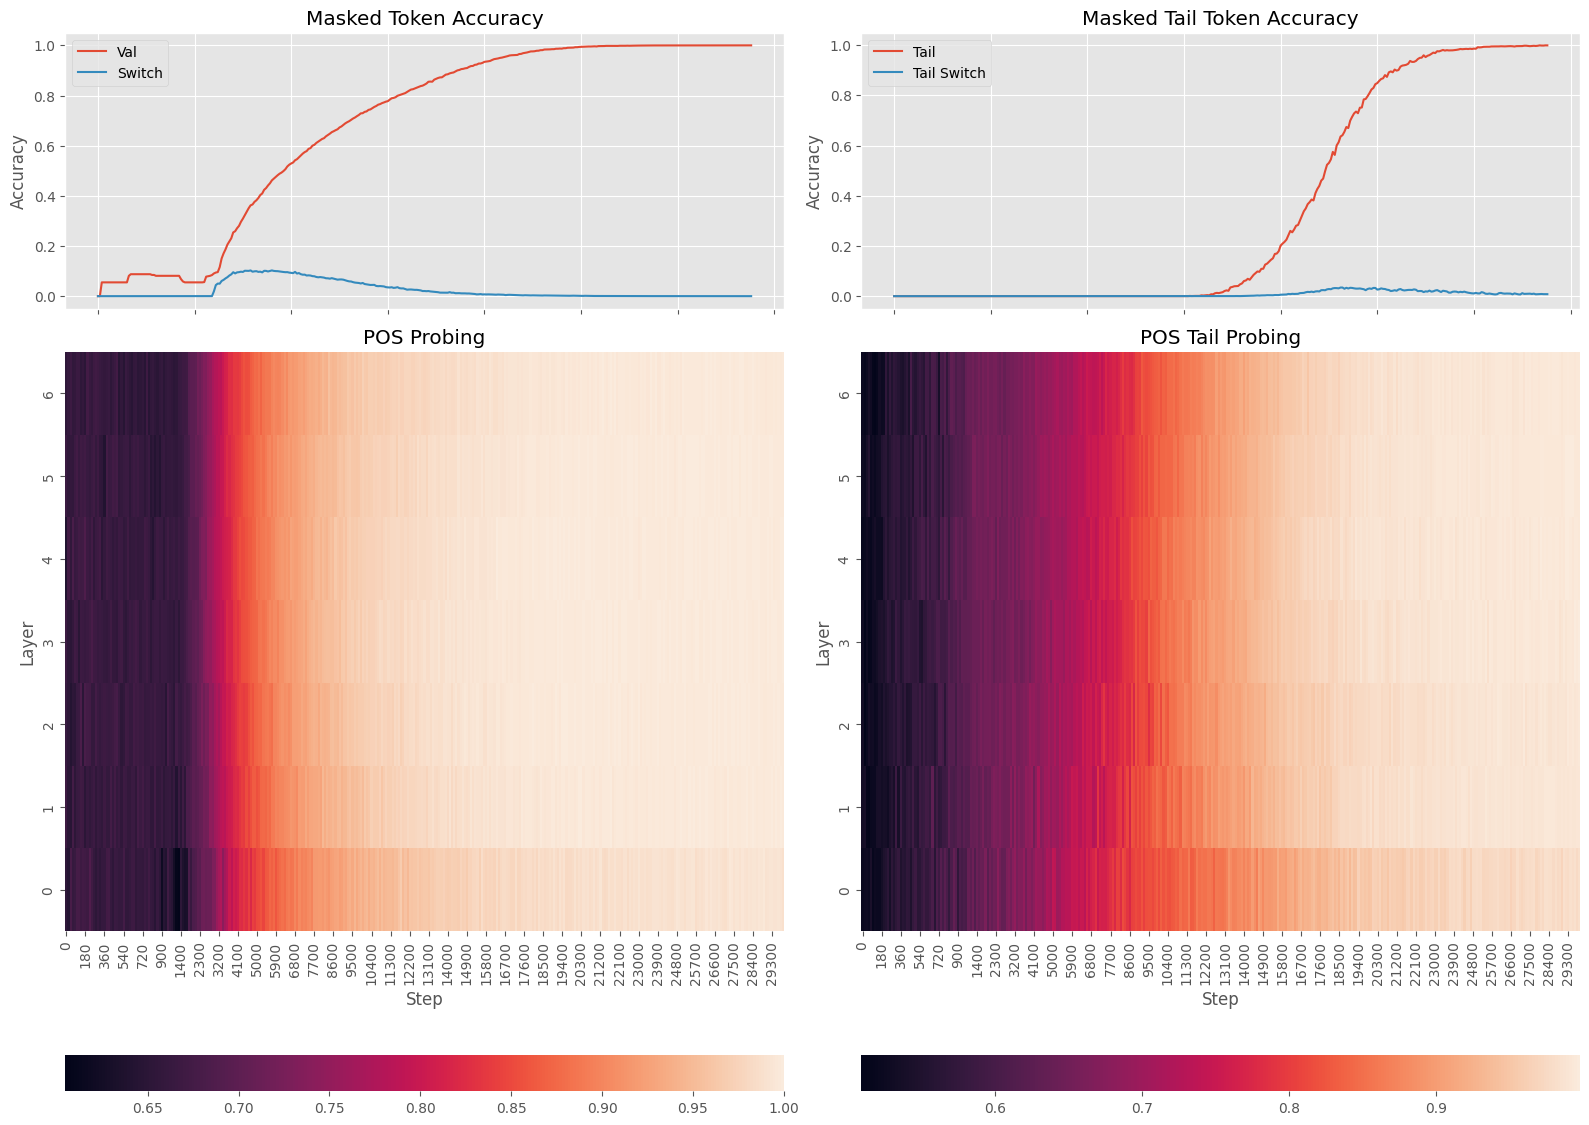

In [8]:
timing_plot_w_tail(prefix="zipf", amb=0.00, vs=10000, a=1.0001, include_switch=True, output_file='../../figures/toy_model/both/zipf_amb=0.00_vs=20000_a=1.5.png')


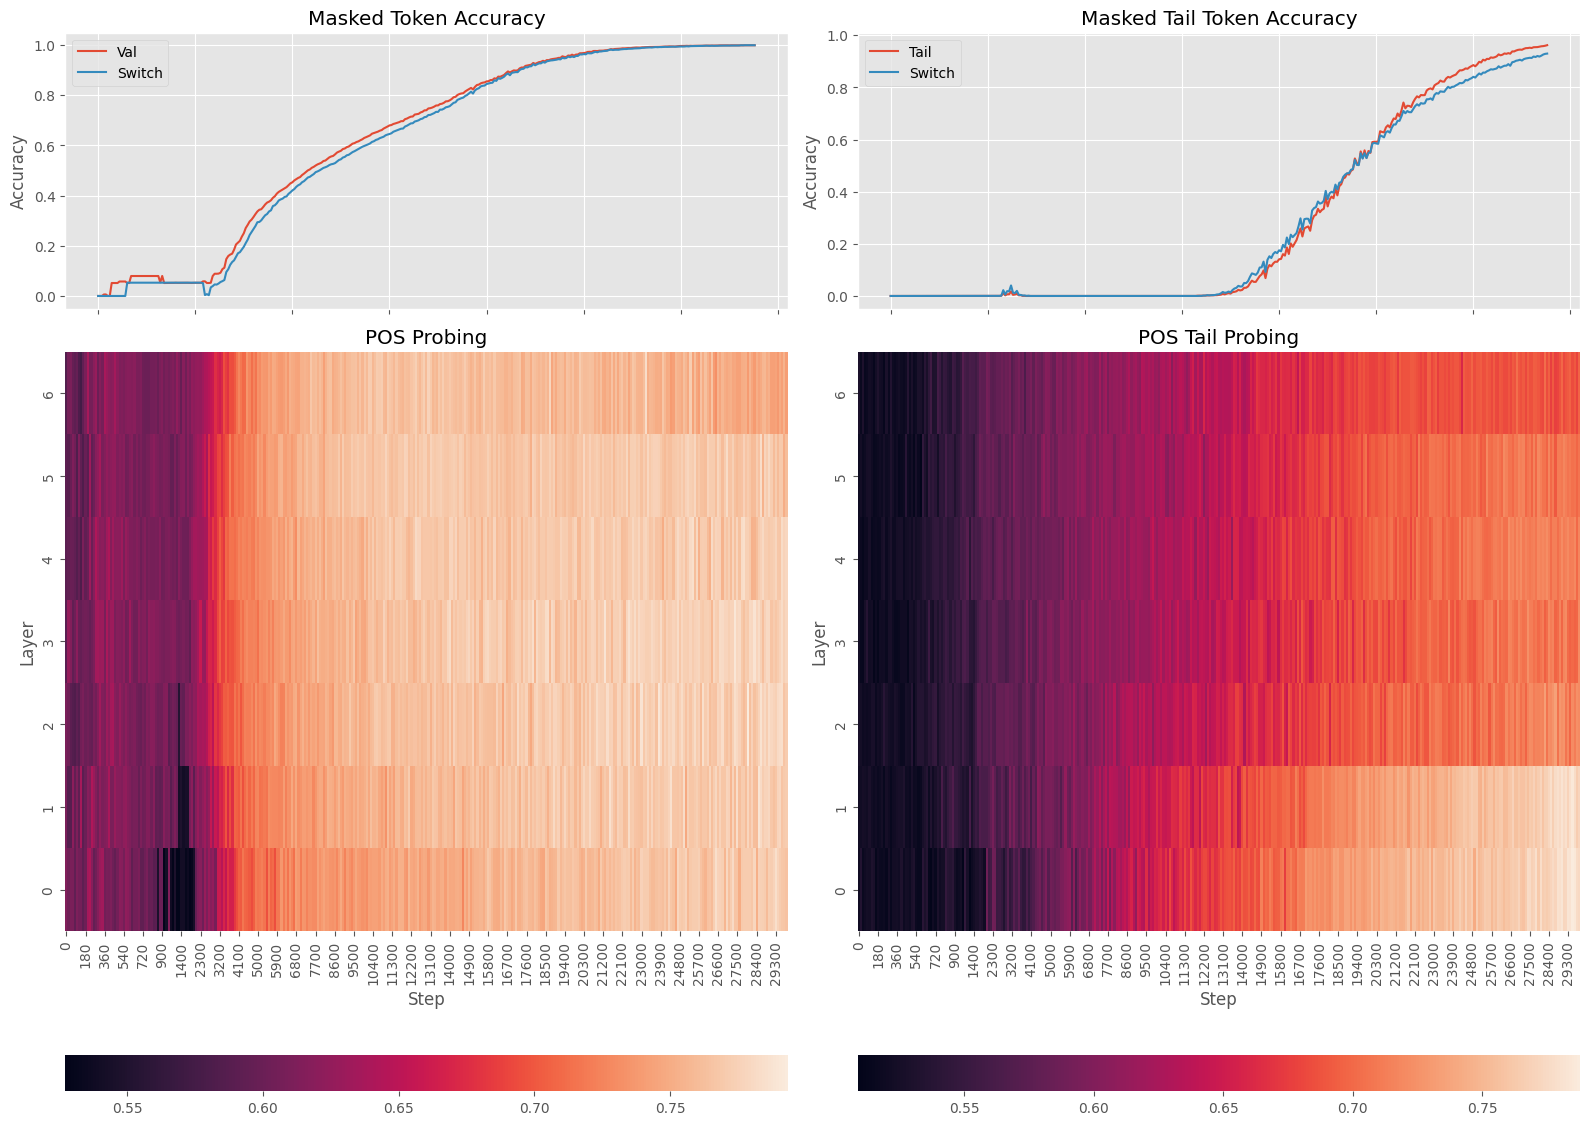

In [52]:
timing_plot_w_tail(prefix="zipf", amb=0.10, vs=20000, a=1.0001, include_switch=True, output_file='../../figures/toy_model/both/zipf_amb=0.10_vs=20000_a=1.5.png')


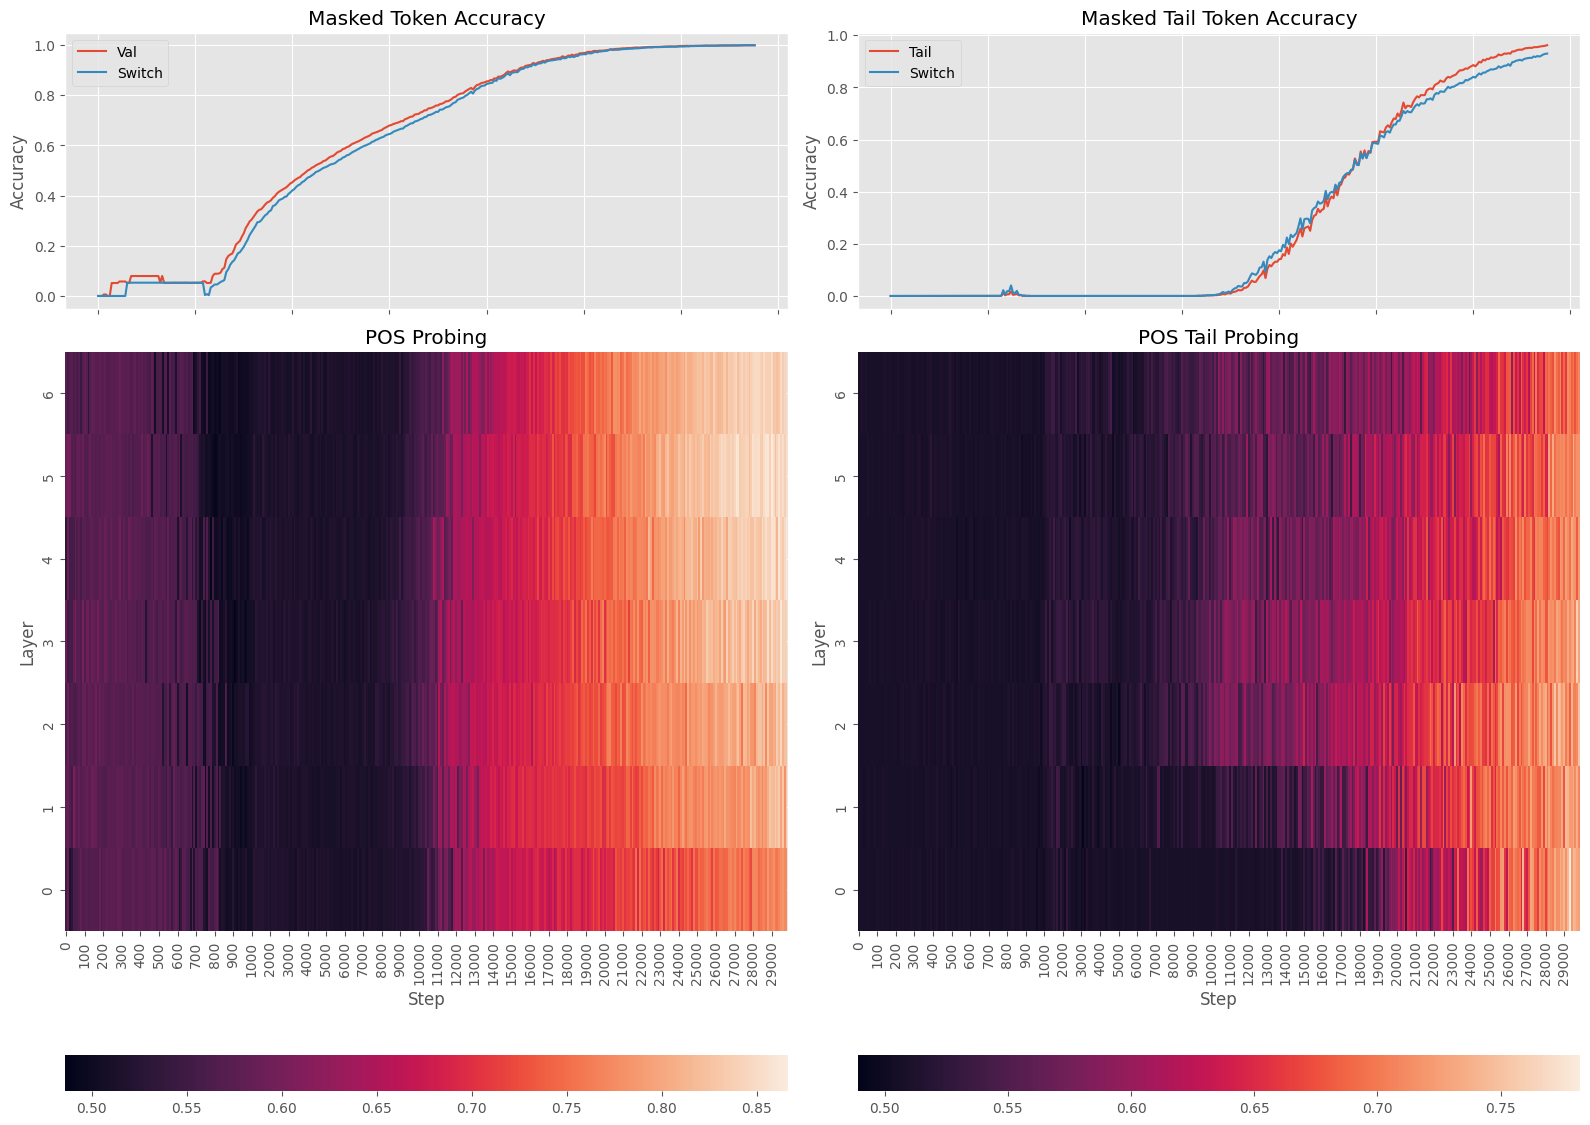

In [37]:
timing_plot_w_tail(prefix="zipf", amb=0.10, vs=20000, a=1.0001, include_switch=True, output_file='../../figures/toy_model/both/zipf_amb=0.10_vs=20000_a=1.0001.png')


In [5]:
# dir = {'zipf': 16, 'zipfb': 32, 'zipfbb': 128}
# for prefix in ["zipf", "zipfb", "zipfbb"]:
#     for vs in [100, 1000, 10000, 20000]:
#         for a in [1.0001, 1.2, 1.5]:
#             try:
#                 dir_num = dir[prefix]
#                 timing_plot_w_tail(prefix=prefix, vs=vs, a=a, include_switch=True, 
#                                    output_file=f'../../figures/toy_model/both/{dir_num}/vs={vs}_a={a}.png')
#             except:
#                 continue

In [39]:
import ast
import json

def plot_hist(prefix='zipf-', output_path='../../figures/toy_model/zipf_16.png'):
    root_directory = '../../outputs/toy_model/'
    csv_roots = []
    for root, dirs, files in os.walk(root_directory):
        if prefix in os.path.basename(root):
            if 'hist.csv' in files and 'hist_tail.csv' in files and 'hist_val.csv' in files and 'hist_switch.csv' in files and 'old' not in root and 'old_params' not in root \
            and 'amb_0.01' not in root: #and 'vs_10000' in root:
                csv_roots.append(root)
    print(csv_roots)
    # csv_files = [f for f in csv_files if '100-' not in f] ## remove 100- files
    nrows = len(csv_roots) // 3 + (len(csv_roots) % 3 > 0)
    ncols = 3
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3.5 * nrows))
    fig.tight_layout(pad=5.0)
    vmax = vmin = None
    
    for i, root in enumerate(csv_roots):
        df = pd.read_csv(os.path.join(root, 'hist.csv'))
        if df['holdout'].dtype != np.float64:
            df['holdout'] = df['holdout'].apply(lambda r: json.loads(r.replace("'", '"'))['acc'])
        if df['holdout_switch'].dtype != np.float64:
            df['holdout_switch'] = df['holdout_switch'].apply(lambda r: json.loads(r.replace("'", '"'))['acc'])
        # df.to_csv(os.path.join(root, 'hist.csv'))

        df.index = df['Unnamed: 0']
        df.drop(['Unnamed: 0'], axis=1, inplace=True)
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

        
        ax = axes[i // ncols, i % ncols]

        for metric in df.columns:
            df[metric].plot(ax=ax)
            
        ax.set_title('-'.join(root.split('/')[-1].split('-')[1:]))
        ax.set_xlabel("Step")
        ax.set_ylabel("Accuracy")

        # if 'amb_0.0' not in root:
        #     ax.legend(['Val', 'Tail', 'Switch', 'Switch Tail'])
        # else:
        ax.legend(df.columns)

    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')
    plt.tight_layout()
    plt.savefig(output_path)

In [40]:
pd.read_csv(os.path.join('../../outputs/toy_model/zipfw-amb_0.0-vs_100-a_1.0001', 'hist.csv'))

Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
0               0             0             0             0          20   
1               1             1             1             1          40   
2               2             2             2             2          60   
3               3             3             3             3          80   
4               4             4             4             4         100   
..            ...           ...           ...           ...         ...   
334           334           334           334           334       29500   
335           335           335           335           335       29600   
336           336           336           336           336       29700   
337           337           337           337           337       29800   
338           338           338           338           338       29900   

          val  tail  switch  tail_switch  holdout  holdout_switch  
0    0.000000   0.0     0.0          0.0      0.0        0.000000  
1    0.111353   0.0     0.0          0.0      0.0        0.000000  
2    0.111353   0.0     0.0          0.0      0.0        0.000000  
3    0.111353   0.0     0.0          0.0      0.0        0.000000  
4    0.205795   0.0     0.0          0.0      0.0        0.000000  
..        ...   ...     ...          ...      ...             ...  
334  1.000000   1.0     0.0          0.0      1.0        0.011768  
335  1.000000   1.0     0.0          0.0      1.0        0.011768  
336  1.000000   1.0     0.0          0.0      1.0        0.011768  
337  1.000000   1.0     0.0          0.0      1.0        0.011867  
338  1.000000   1.0     0.0          0.0      1.0        0.011867  

[339 rows x 11 columns]

['../../outputs/toy_model/zipfw-amb_0.0-vs_100-a_1.0001', '../../outputs/toy_model/zipfw-amb_0.0-vs_100-a_1.2', '../../outputs/toy_model/zipfw-amb_0.0-vs_100-a_1.5', '../../outputs/toy_model/zipfw-amb_0.0-vs_1000-a_1.0001', '../../outputs/toy_model/zipfw-amb_0.0-vs_1000-a_1.2', '../../outputs/toy_model/zipfw-amb_0.0-vs_1000-a_1.5', '../../outputs/toy_model/zipfw-amb_0.0-vs_10000-a_1.0001', '../../outputs/toy_model/zipfw-amb_0.0-vs_10000-a_1.2', '../../outputs/toy_model/zipfw-amb_0.0-vs_10000-a_1.5', '../../outputs/toy_model/zipfw-amb_0.0-vs_20000-a_1.0001', '../../outputs/toy_model/zipfw-amb_0.0-vs_20000-a_1.2', '../../outputs/toy_model/zipfw-amb_0.10-vs_100-a_1.0001', '../../outputs/toy_model/zipfw-amb_0.10-vs_100-a_1.2', '../../outputs/toy_model/zipfw-amb_0.10-vs_100-a_1.5', '../../outputs/toy_model/zipfw-amb_0.10-vs_1000-a_1.0001', '../../outputs/toy_model/zipfw-amb_0.10-vs_1000-a_1.2', '../../outputs/toy_model/zipfw-amb_0.10-vs_1000-a_1.5', '../../outputs/toy_model/zipfw-amb_0.10-v

/tmp/ipykernel_761555/2807027415.py:50: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


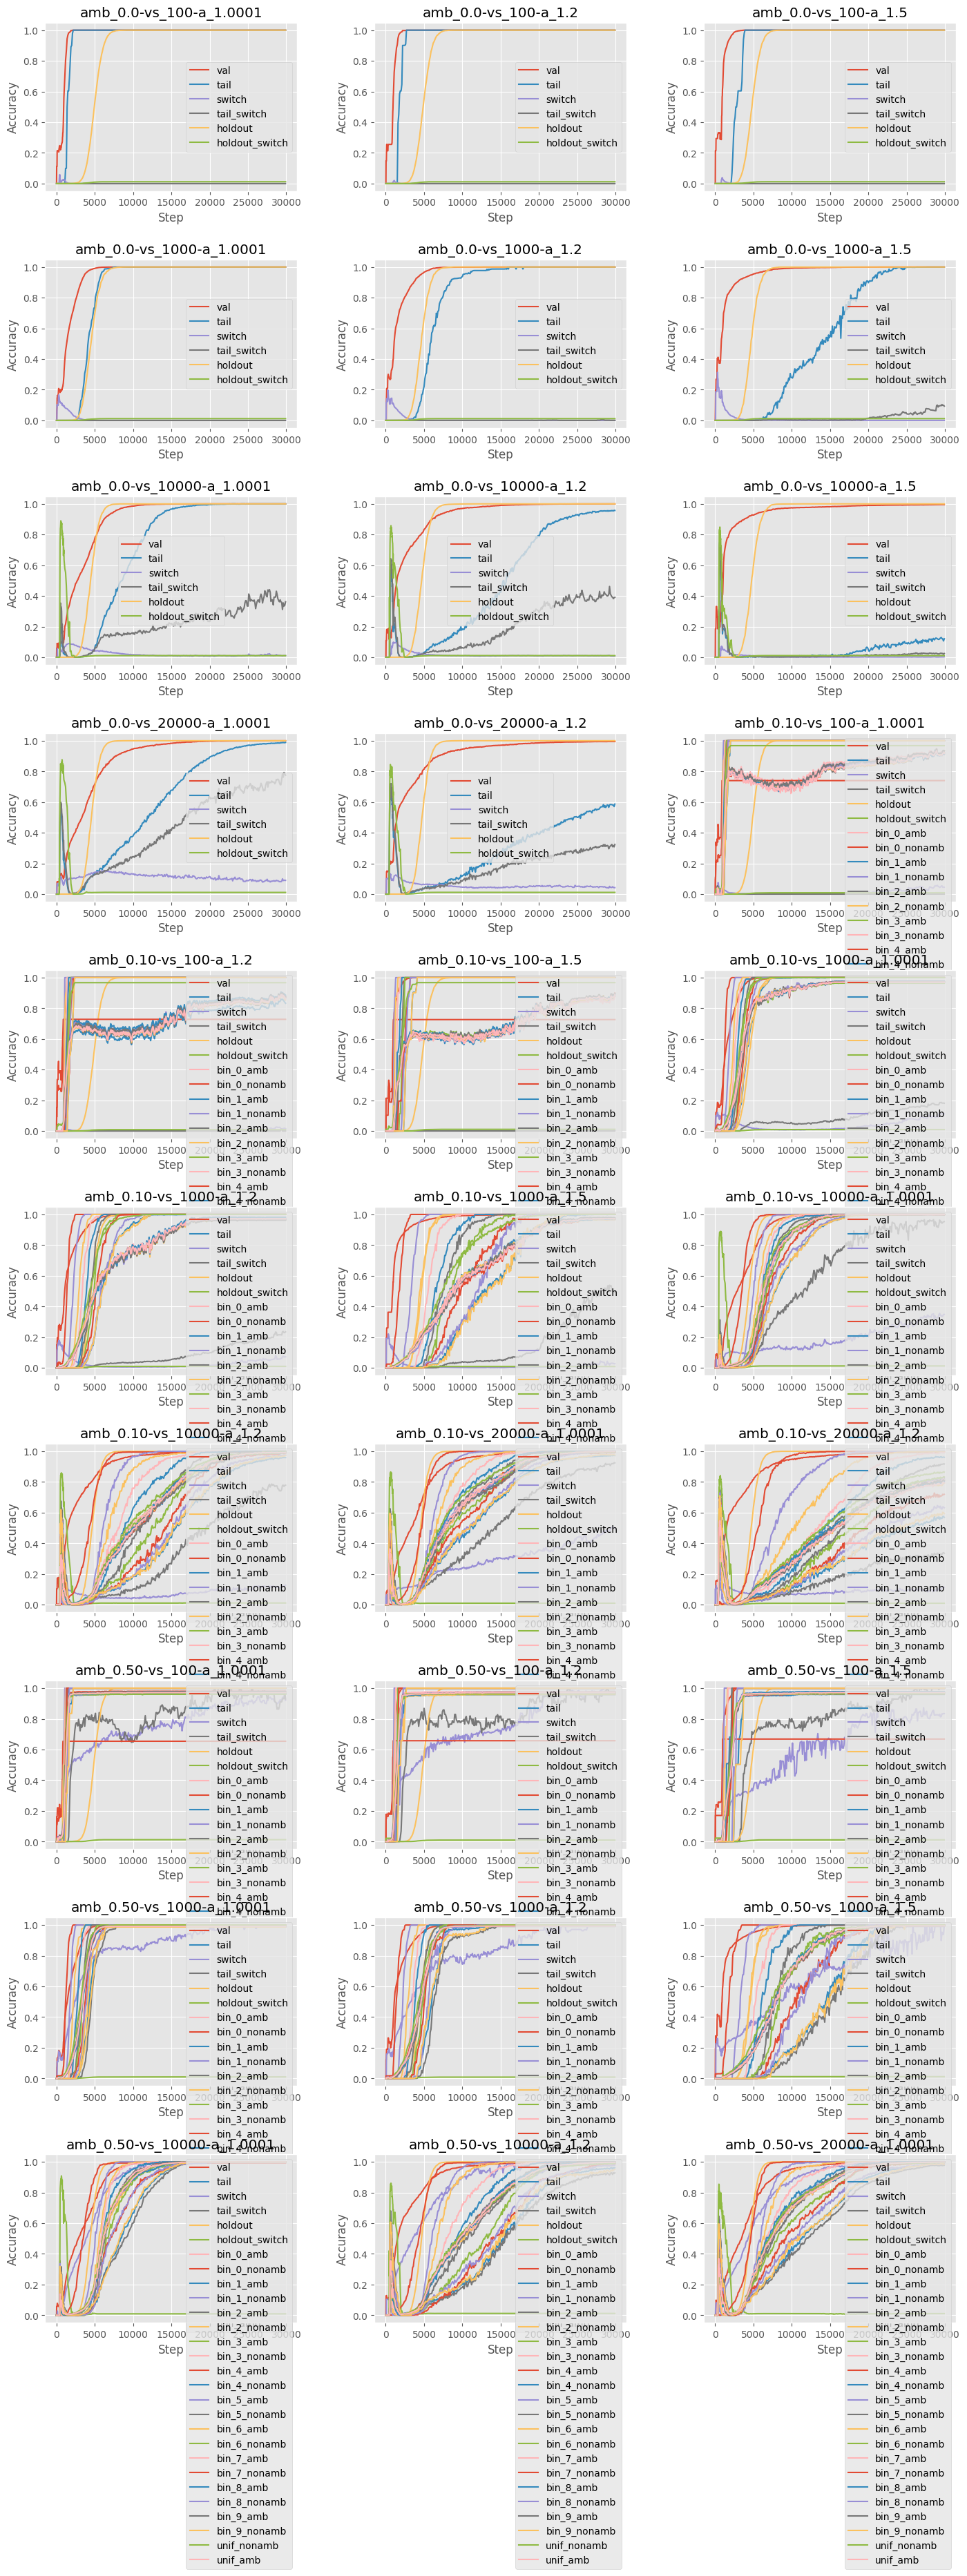

In [41]:
plot_hist(prefix='zipfw-', output_path='../../figures/toy_model/0.0-w-zipf_64_amb.png')

In [15]:
def plot_grid_acc(prefix='zipf-', output_path='../../figures/toy_model/zipf_16.png'):
    root_directory = '../../outputs/toy_model/'
    csv_roots = []
    for root, dirs, files in os.walk(root_directory):
        if prefix in os.path.basename(root):
            if 'hist_tail.csv' in files and 'hist_val.csv' in files and 'hist_switch.csv' in files and 'old' not in root and 'old_params' not in root \
            and 'amb_0.01' not in root: #and 'vs_10000' in root:
                csv_roots.append(root)
    print(csv_roots)
    # csv_files = [f for f in csv_files if '100-' not in f] ## remove 100- files
    nrows = len(csv_roots) // 3 + (len(csv_roots) % 3 > 0)
    ncols = 3
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3.5 * nrows))
    fig.tight_layout(pad=5.0)
    vmax = vmin = None
    
    for i, root in enumerate(csv_roots):
        dfs = []
        df_val = pd.read_csv(os.path.join(root, 'hist_val.csv'))
        # df_random = pd.read_csv(os.path.join(root, 'hist_random.csv'))
        df_tail = pd.read_csv(os.path.join(root, 'hist_tail.csv'))
        df_switch = pd.read_csv(os.path.join(root, 'hist_switch.csv'))
        df_tail_switch = pd.read_csv(os.path.join(root, 'hist_tail_switch.csv'))
        dfs = [df_val, df_tail, df_switch, df_tail_switch]
        if 'amb_0.0' not in root:
            df_amb = pd.read_csv(os.path.join(root, 'hist_amb.csv'))
            df_nonamb = pd.read_csv(os.path.join(root, 'hist_nonamb.csv'))
            dfs.extend([df_amb, df_nonamb])

        ax = axes[i // ncols, i % ncols]
        for df in dfs:
            acc = df[df['Unnamed: 0'] == 'acc'].drop('Unnamed: 0', axis=1)
            acc.iloc[0].plot(ax=ax)
            
        ax.set_title('-'.join(root.split('/')[-1].split('-')[1:]))
        ax.set_xlabel("Step")
        ax.set_ylabel("Accuracy")

        # if 'amb_0.0' not in root:
        #     ax.legend(['Val', 'Tail', 'Switch', 'Switch Tail'])
        # else:
        ax.legend(['Val', 'Tail', 'Switch', 'Switch Tail', 'Amb', 'Nonamb'])

    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')
    plt.tight_layout()
    plt.savefig(output_path)

['../../outputs/toy_model/zipfh-amb_0.0-vs_100-a_1.0001', '../../outputs/toy_model/zipfh-amb_0.0-vs_100-a_1.2', '../../outputs/toy_model/zipfh-amb_0.0-vs_100-a_1.5', '../../outputs/toy_model/zipfh-amb_0.0-vs_1000-a_1.0001', '../../outputs/toy_model/zipfh-amb_0.0-vs_1000-a_1.2', '../../outputs/toy_model/zipfh-amb_0.0-vs_1000-a_1.5', '../../outputs/toy_model/zipfh-amb_0.0-vs_10000-a_1.0001', '../../outputs/toy_model/zipfh-amb_0.0-vs_10000-a_1.2', '../../outputs/toy_model/zipfh-amb_0.0-vs_10000-a_1.5', '../../outputs/toy_model/zipfh-amb_0.0-vs_20000-a_1.0001', '../../outputs/toy_model/zipfh-amb_0.0-vs_20000-a_1.2', '../../outputs/toy_model/zipfh-amb_0.0-vs_20000-a_1.5', '../../outputs/toy_model/zipfh-amb_0.10-vs_100-a_1.0001', '../../outputs/toy_model/zipfh-amb_0.10-vs_100-a_1.2', '../../outputs/toy_model/zipfh-amb_0.10-vs_100-a_1.5', '../../outputs/toy_model/zipfh-amb_0.10-vs_1000-a_1.0001', '../../outputs/toy_model/zipfh-amb_0.10-vs_1000-a_1.2', '../../outputs/toy_model/zipfh-amb_0.10-v

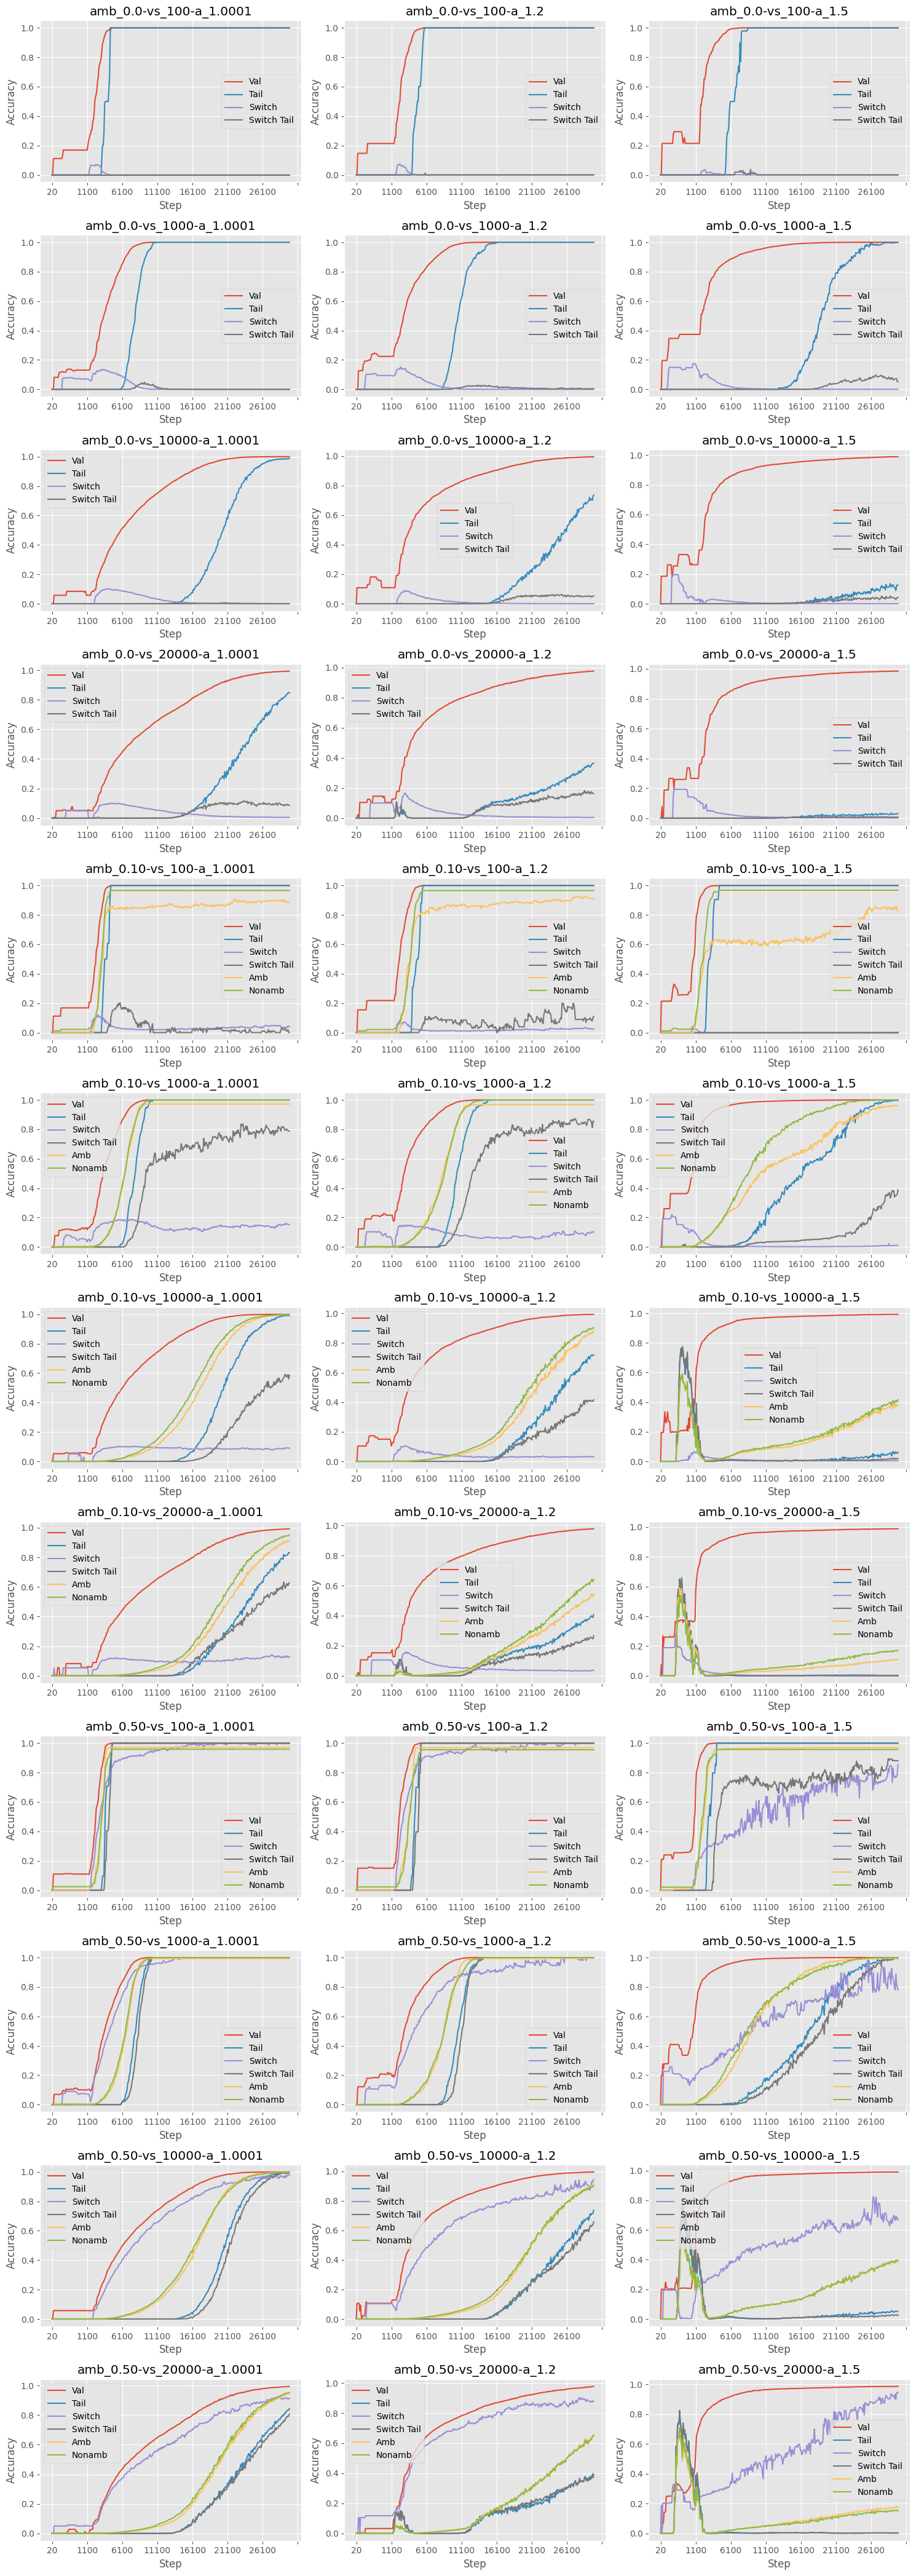

In [16]:
plot_grid_acc(prefix='zipfh-', output_path='../../figures/toy_model/0.1-wd-zipf_64_amb.png')

['../../outputs/toy_model/zipfw-amb_0.0-vs_100-a_1.0001', '../../outputs/toy_model/zipfw-amb_0.0-vs_100-a_1.2', '../../outputs/toy_model/zipfw-amb_0.0-vs_100-a_1.5', '../../outputs/toy_model/zipfw-amb_0.0-vs_1000-a_1.0001', '../../outputs/toy_model/zipfw-amb_0.0-vs_1000-a_1.2', '../../outputs/toy_model/zipfw-amb_0.0-vs_1000-a_1.5', '../../outputs/toy_model/zipfw-amb_0.0-vs_10000-a_1.0001', '../../outputs/toy_model/zipfw-amb_0.0-vs_10000-a_1.2', '../../outputs/toy_model/zipfw-amb_0.0-vs_10000-a_1.5', '../../outputs/toy_model/zipfw-amb_0.0-vs_20000-a_1.0001', '../../outputs/toy_model/zipfw-amb_0.0-vs_20000-a_1.2', '../../outputs/toy_model/zipfw-amb_0.0-vs_20000-a_1.5', '../../outputs/toy_model/zipfw-amb_0.10-vs_100-a_1.0001', '../../outputs/toy_model/zipfw-amb_0.10-vs_100-a_1.2', '../../outputs/toy_model/zipfw-amb_0.10-vs_100-a_1.5', '../../outputs/toy_model/zipfw-amb_0.10-vs_1000-a_1.0001', '../../outputs/toy_model/zipfw-amb_0.10-vs_1000-a_1.2', '../../outputs/toy_model/zipfw-amb_0.10-v

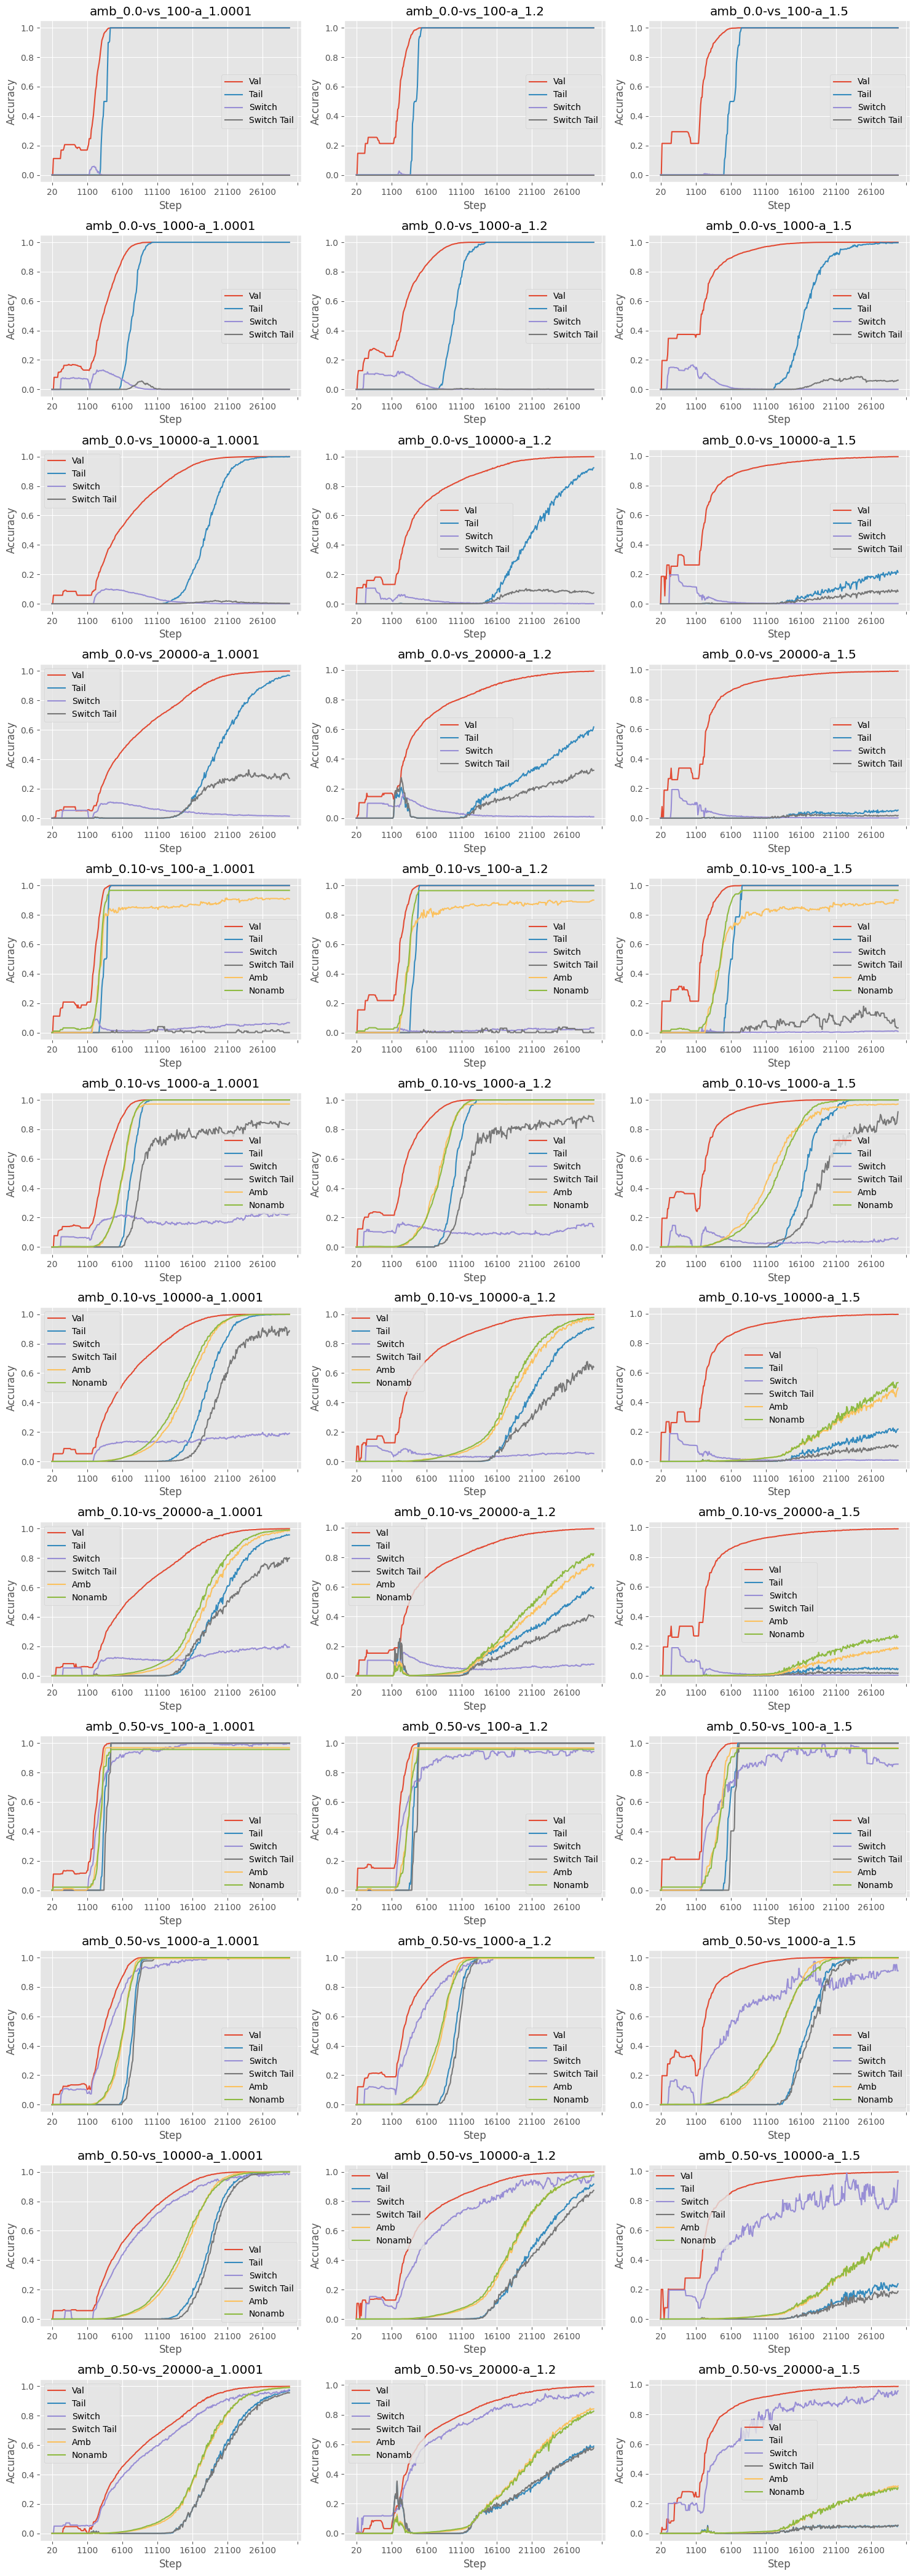

In [17]:
plot_grid_acc(prefix='zipfw-', output_path='../../figures/toy_model/no-wd-zipf_64_amb.png')

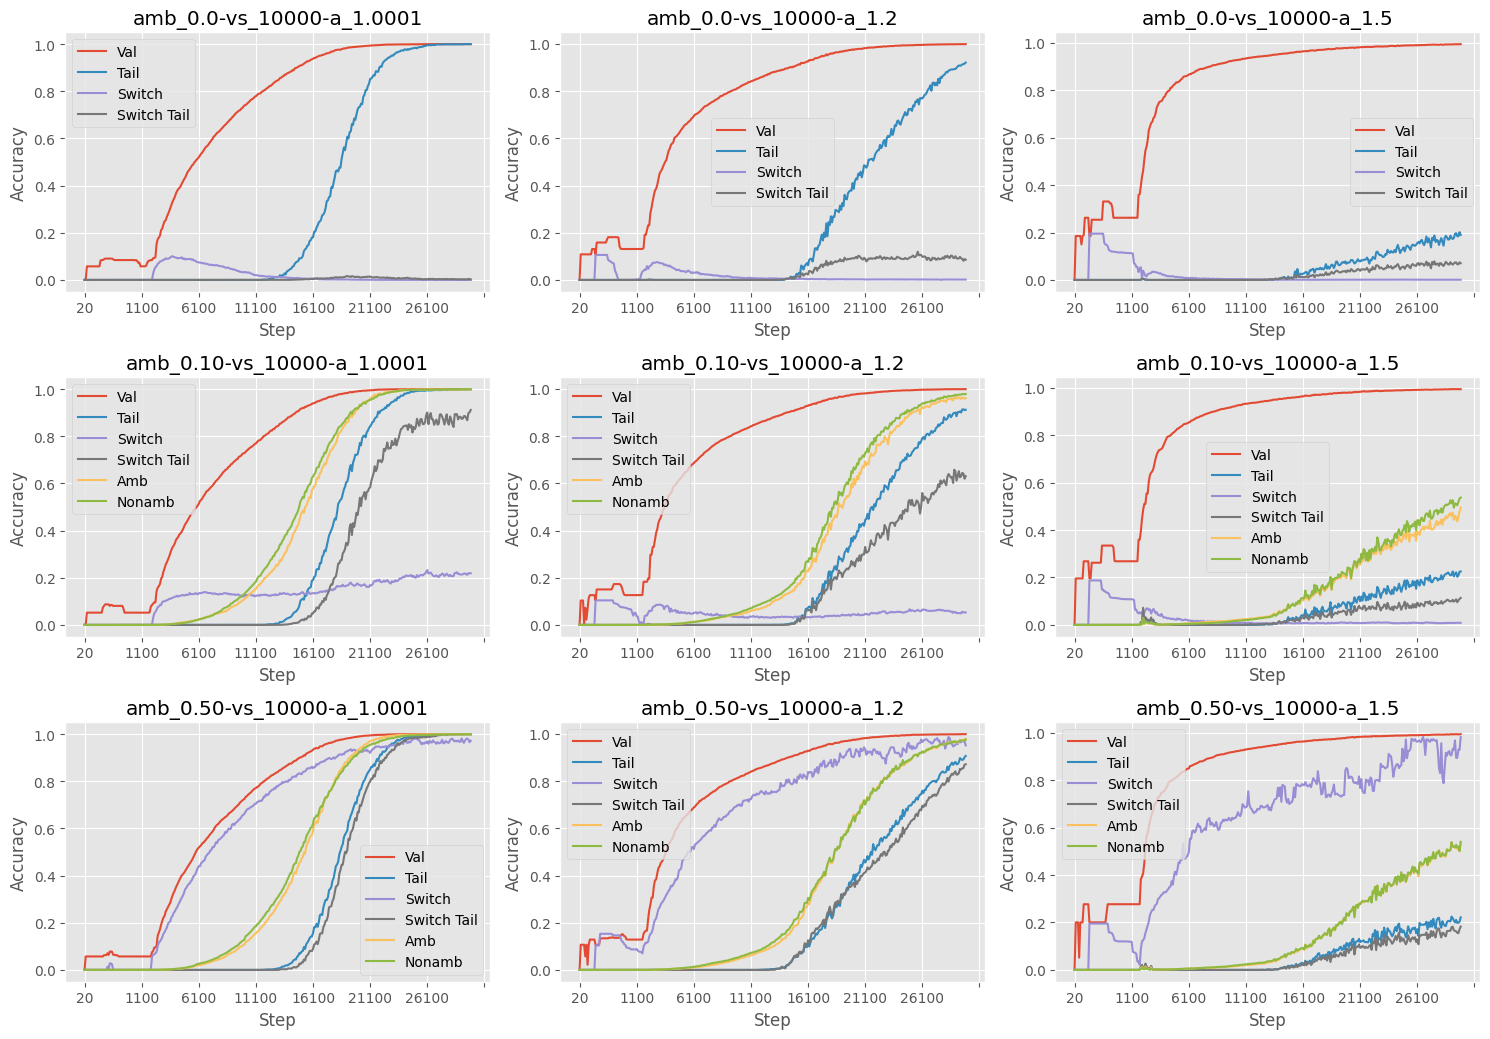

In [23]:
# plot_grid_acc(prefix='zipf-', output_path='../../figures/toy_model/zipf_16_acc.png')
# plot_grid_acc(prefix='zipfb-', output_path='../../figures/toy_model/zipf_32_acc.png')
plot_grid_acc(prefix='zipfr-', output_path='../../figures/toy_model/zipf_64_amb.png')

In [12]:
def plot_grid(prefix='zipf-', output_path='../../figures/toy_model/zipf_16.png', tail=False):
    root_directory = '../../outputs/toy_model/'
    csv_files = []
    for root, dirs, files in os.walk(root_directory):
        if os.path.basename(root).startswith(prefix):
            for file in files:
                if file.endswith(f'probing{"_tail" if tail else ""}_results.csv') and 'old' not in root and 'old_params' not in root:
                    csv_files.append(os.path.join(root, file))
    
    # csv_files = [f for f in csv_files if '100-' not in f] ## remove 100- files
    nrows = len(csv_files) // 3 + (len(csv_files) % 3 > 0)
    ncols = 3
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3.5 * nrows))
    fig.tight_layout(pad=5.0)
    vmax = vmin = None
    
    for file in csv_files:
        df = pd.read_csv(file)
        if 'Unnamed: 0' in df.columns:
            df = df.drop('Unnamed: 0', axis=1)
        vmax = max(df.max().max(), vmax) if vmax is not None else df.max().max()
        vmin = min(df.min().min(), vmin) if vmin is not None else df.min().min()
    
    for i, file in enumerate(csv_files):
        df = pd.read_csv(file)
        if 'Unnamed: 0' in df.columns:
            df = df.drop('Unnamed: 0', axis=1)
        df.index = df.index[::-1]
        # df = df[[str(x) for x in list(range(8000, 28000, 1000))]]
        ax = axes[i // ncols, i % ncols]
        sns.heatmap(df, ax=ax) #vmin=vmin, vmax=vmax, cbar=i == len(csv_files) - 1)
        # print(file)
        ax.set_title('-'.join(file.split('/')[4].replace('unif-', '').split('-')[1:]))  # Set subtitle as file name (without extension)
    
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')
    plt.tight_layout()
    plt.savefig(output_path)

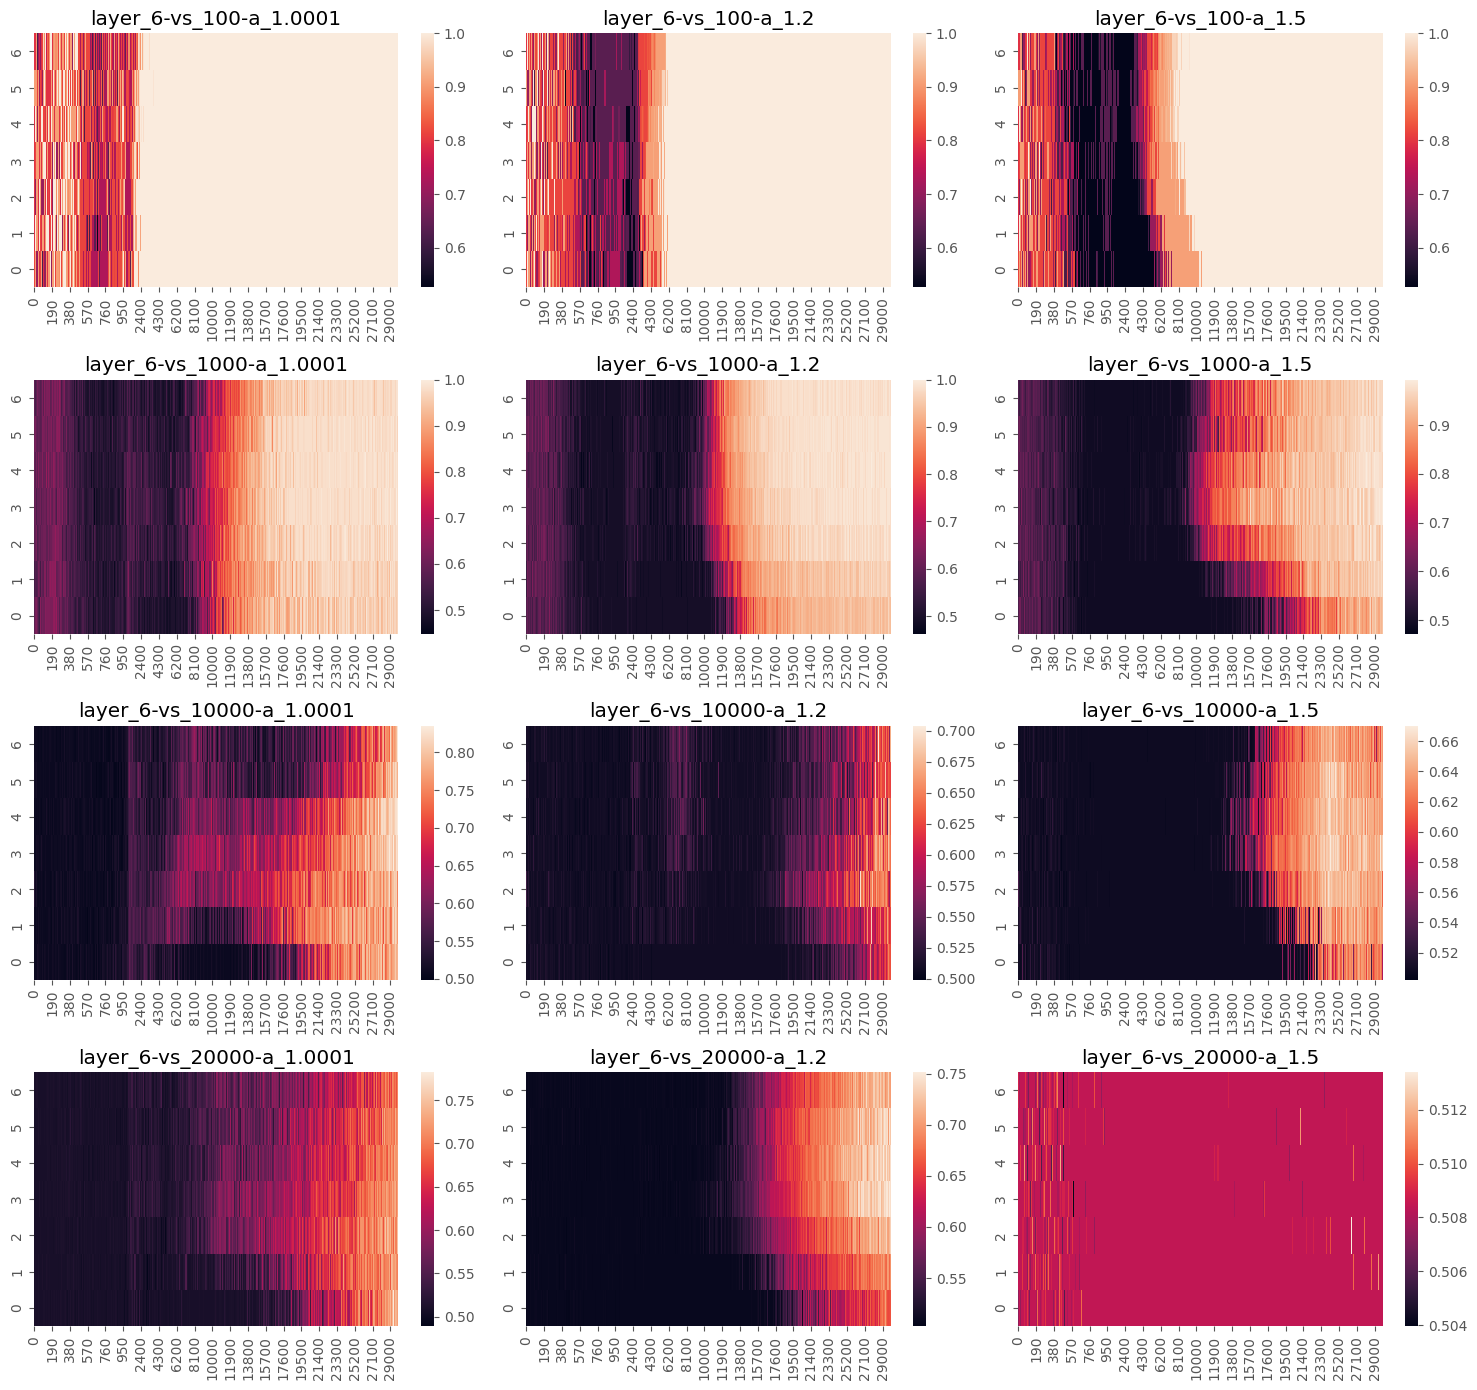

In [13]:
# plot_grid(prefix='zipf-', output_path='../../figures/toy_model/zipf_16.png', tail=False)
plot_grid(prefix='zipf-', output_path='../../figures/toy_model/zipf_tail_16.png', tail=True)
# plot_grid(prefix='zipfb-', output_path='../../figures/toy_model/zipf_32.png', tail=False)
# plot_grid(prefix='zipfb-', output_path='../../figures/toy_model/zipf_tail_32.png', tail=True)
# plot_grid(prefix='zipfbb-', output_path='../../figures/toy_model/zipf_128.png', tail=False)
# plot_grid(prefix='zipfbb-', output_path='../../figures/toy_model/zipf_tail_32.png', tail=True)

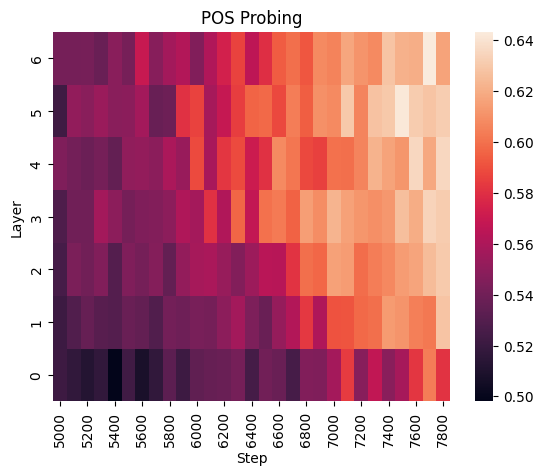

In [27]:
df = pd.read_csv('../../outputs/toy_model/old_params/zipf-layer_6-vs_10000-a_1.0001/pos_probing_results.csv')
df.index = df['Unnamed: 0']
df = df.drop('Unnamed: 0', axis=1)
ax = sns.heatmap(df, annot=False)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("POS Probing")
plt.show()
# plt.savefig(os.path.join(output_dir, 'pos_probing_steps.png'))


In [4]:
pythia = AutoModel.from_pretrained('EleutherAI/pythia-160m')
bert = AutoModel.from_pretrained('google/multiberts-seed_0-step_0k')

#### Make Deterministic Plz

In [6]:
class Probe(nn.Module):
    def __init__(dset_gen, num_features: int):
        super().__init__()
        dset_gen.body = nn.Linear(num_features, 1, bias=False)

    def forward(dset_gen, x):
        if isinstance(x, list):
            x, _ = x
        return dset_gen.body(x)
        
def bin_step(model, batch):
    x, y = batch
    logits = model.forward(x)
    loss = F.binary_cross_entropy(torch.sigmoid(logits), y)
    acc = ((logits.squeeze() > 0.5).float() == y.squeeze()).float().mean()
    return loss, {"loss": loss.item(), "acc": acc.item()}

def bin_train_loop(model, train_dataloader, test_dataloader, optimizer, epochs):
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        pbar.set_description(f"Training Epoch {epoch}")
        for batch in train_dataloader:
            model.train()
            optimizer.zero_grad()
            loss, stats = bin_step(model, batch)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(**stats)
            
        model.eval()
        with torch.no_grad():
            pbar.set_description("Validation")
            results = bin_val_loop(model, test_dataloader)
    return results

def bin_val_loop(model, test_dataloader):
    model.eval()
    acc, losses = [], []
    with torch.no_grad():
        pbar = tqdm(test_dataloader)
        for val_batch in pbar:
            loss, stats = bin_step(model, val_batch)
            acc.append(stats["acc"])
            losses.append(stats["loss"])
            results = {"acc": np.mean(acc), "loss": np.mean(losses)}
            pbar.set_postfix(**results)
    return results

In [31]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)

## BERT VOCAB MODEL

### Task POS

In [32]:
num_pos_tokens = 100
assert num_pos_tokens % 2 == 0, "Has to be even"

special_token_dict_pos = {
    'cop': num_pos_tokens,
    'null': num_pos_tokens+1,
    'mask': num_pos_tokens+2
}
noun_tokens = range(num_pos_tokens//2)
adj_tokens = range(num_pos_tokens//2, num_pos_tokens)

def uniform(type='noun'):
    assert type in ['noun', 'adj'], "type not found"
    return random.choice(noun_tokens) if type == 'noun' else random.choice(adj_tokens)

def zipfian(type='noun', a=1.5):
    assert type in ['noun', 'adj'], "type not found"
    if type == 'noun':
        map = {k:v for k,v in zip(range(len(noun_tokens)), noun_tokens)}
    else:
        map = {k:v for k,v in zip(range(len(adj_tokens)), adj_tokens)}    
    value = np.random.zipf(a)
    while value not in map.keys():
        value = np.random.zipf(a)
    return map[value]

def create_dataset_task_pos(num_examples, mask_probability=0.15, masking='train', sample_func=zipfian):
    dataset = []
    labels = []
    alt_labels = []
    for _ in range(num_examples):
        rand_val = random.random()
        if rand_val < 0.40:
            noun = sample_func('noun')
            seq = [special_token_dict_pos['cop'], special_token_dict_pos['null'], noun]
            if rand_val < 0.20:
                adj = random.choice(adj_tokens)
                seq.extend([adj, special_token_dict_pos['null'], special_token_dict_pos['null'], special_token_dict_pos['null']])
            else:
                seq.extend([noun, special_token_dict_pos['null'], noun, noun])
            seq_alt = seq.copy()
              
        elif rand_val < 0.80: 
            noun = sample_func('noun')
            seq = [noun, special_token_dict_pos['cop'], special_token_dict_pos['null']]
            if rand_val < 0.60:
                adj = random.choice(adj_tokens)
                seq.extend([adj, special_token_dict_pos['null'], special_token_dict_pos['null'], special_token_dict_pos['null']])
            else:
                seq.extend([noun, special_token_dict_pos['null'], noun, noun])
            seq_alt = seq.copy()

        elif rand_val < 0.90: 
            adj, noun = sample_func('adj'), sample_func('noun')
            seq = [special_token_dict_pos['cop'], adj, noun]
            seq_alt = seq.copy()
            if rand_val < 0.85:
                seq.extend([adj, adj, adj, adj])
                seq_alt.extend([adj, special_token_dict_pos['null'], special_token_dict_pos['null'], special_token_dict_pos['null']])
            else:
                seq.extend([noun, adj, noun, noun])
                seq_alt.extend([noun, special_token_dict_pos['null'], noun, noun])
                
        else:
            adj, noun = sample_func('adj'), sample_func('noun')
            seq = [noun, special_token_dict_pos['cop'], adj]
            seq_alt = seq.copy()
            if rand_val < 0.95:
                seq.extend([adj, adj, adj, adj])
                seq_alt.extend([adj, special_token_dict_pos['null'], special_token_dict_pos['null'], special_token_dict_pos['null']])
            else:
                seq.extend([noun, adj, noun, noun])
                seq_alt.extend([noun, special_token_dict_pos['null'], noun, noun])

        label_seq = seq.copy()
        alt_labels_seq = seq_alt.copy()
        
        if masking=='train':
            for i in range(len(seq)):
                if random.random() < mask_probability:
                    seq[i] = special_token_dict_pos['mask']
                else:
                    label_seq[i] = -100 # ignore in loss fxn
                    alt_labels_seq[i] = -100
        else:
            for i in range(len(seq)):
                if i >= len(seq) - 3:
                    seq[i] = special_token_dict_pos['mask']
                else:
                    label_seq[i] = -100
                    alt_labels_seq[i] = -100
        dataset.append(seq)
        labels.append(label_seq)
        alt_labels.append(alt_labels_seq)

    return dataset, labels, alt_labels

In [33]:
ns1 = [zipfian('noun') for _ in range(1000)]

In [29]:
ns = [zipfian('noun') for _ in range(1000)]

(array([740.,  91.,  48.,  36.,  32.,  19.,  11.,  10.,   7.,   6.]),
 array([ 1. ,  5.7, 10.4, 15.1, 19.8, 24.5, 29.2, 33.9, 38.6, 43.3, 48. ]),
 <BarContainer object of 10 artists>)

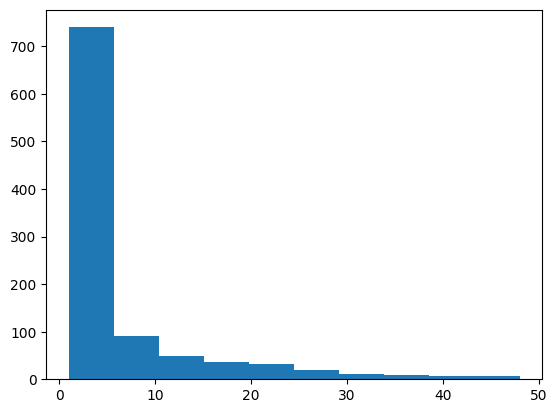

In [30]:
plt.hist(ns)

### Task DEP

In [9]:
special_token_dict_dep = {
    'mask': 400
}
seq_tokens = range(0, 400)
example_len = 20

## try + make harder 
## even smaller w the model

def generate_sequence(length, start_value, step_probability):
    sequence = [start_value]
    current_value = start_value

    for _ in range(length - 1):
        if random.random() < step_probability:
            # Change the value with the defined step change
            current_value += 1
        sequence.append(current_value)
    return sequence
    
def create_dataset_task_dep(num_examples, mask_probability=0.15, masking='train', elastic=True, step_prob = 0.90):
    assert example_len % 2 == 0, "example len must be even"
    seq_len = example_len // 2
    
    dataset = []
    labels = []
    alt_labels = []
    for _ in range(num_examples):
        rand_val = random.random()
        start_index = random.randint(0, len(seq_tokens) - seq_len)
        if elastic:
            seq = generate_sequence(seq_len, seq_tokens[start_index], step_prob) ## can have repeats
        else:
            seq = list(seq_tokens[start_index:start_index + seq_len])
        
        if rand_val < 0.80:
            seq *= 2
            seq_alt = seq.copy()
        else:
            if elastic: 
                change_ind = random.choice(range(2, seq_len+1))
                seq[-change_ind+1], seq[-change_ind] = seq[-change_ind], seq[-change_ind+1]
                seq *= 2
                seq_alt = seq.copy()
                seq[-change_ind+1] = seq[-change_ind]
            else:
                seq[-1], seq[-2] = seq[-2], seq[-1]
                seq *= 2
                seq_alt = seq.copy()
                seq[-1] = seq[-2]

        label_seq = seq.copy()
        alt_labels_seq = seq_alt.copy()
        
        if masking=='train':
            for i in range(len(seq)):
                if random.random() < mask_probability:
                    seq[i] = special_token_dict_dep['mask']
                else:
                    label_seq[i] = -100 # ignore in loss fxn
                    alt_labels_seq[i] = -100
        else:
            for i in range(len(seq)):
                if i >= len(seq) - seq_len:
                    seq[i] = special_token_dict_dep['mask']
                else:
                    label_seq[i] = -100
                    alt_labels_seq[i] = -100
        dataset.append(seq)
        labels.append(label_seq)
        alt_labels.append(alt_labels_seq)
        
    return dataset, labels, alt_labels

### Dataloader Helper

In [10]:
def create_dataloaders(num_train, num_val, device="cpu", task=create_dataset_task_pos):
    inputs_t, labels_t, alt_labels_t = task(num_train, mask_probability=0.15, masking='test')
    inputs_v, labels_v, alt_labels_v = task(num_val, mask_probability=0, masking='test')
    
    inputs_t = torch.tensor(inputs_t).to(device)
    labels_t = torch.tensor(labels_t).to(device)
    alt_labels_t = torch.tensor(alt_labels_t).to(device)
    inputs_v = torch.tensor(inputs_v).to(device)
    labels_v = torch.tensor(labels_v).to(device)
    alt_labels_v = torch.tensor(alt_labels_v).to(device)

    train_dataset = TensorDataset(inputs_t.detach(), labels_t, alt_labels_t)
    val_dataset = TensorDataset(inputs_v.detach(), labels_v, alt_labels_v)
    
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)
    
    return train_dataloader, val_dataloader

def create_dataloaders_bin(data, labels, device="cpu"):
    train_len = int(0.80 * len(data))
    inputs_t, labels_t = data[:train_len], labels[:train_len]
    inputs_v, labels_v = data[train_len:], labels[train_len:]
    train_dataset = TensorDataset(inputs_t.detach(), labels_t.view(-1, 1))
    val_dataset = TensorDataset(inputs_v.detach(), labels_v.view(-1, 1))
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    return train_dataloader, val_dataloader


### Training BERT Helpers

In [11]:
def pca_pos(model, val_dataloader, title, c_step, probe_results=defaultdict(list)):
    labels, hidden_layers = [], defaultdict(list)
    model.config.output_hidden_states=True
    num_hidden_states = model.config.num_hidden_layers + 1
    fig, axs = plt.subplots(1, num_hidden_states, figsize=(5*num_hidden_states, 5))
    
    for batch in val_dataloader:
        examples, _, _ = batch
        labels.append((examples[:, -4] < 50).float())
        with torch.no_grad():
            outputs = model(examples.to(device))
        for j in range(num_hidden_states):
            hidden_layers[j].append(outputs.hidden_states[j][:, -4, :])
    
    labels = torch.concat(labels, axis=0).unsqueeze(1)
    for i in range(num_hidden_states):
        torch_embed = torch.concat(hidden_layers[i], axis=0).squeeze()
        probe = Probe(torch_embed.shape[1]).to(model.device)
        train_dataloader_bin, val_dataloader_bin = create_dataloaders_bin(torch_embed, labels, device=model.device)
        optim_bin = torch.optim.AdamW(probe.parameters(), lr=1e-3) 
        
        results = bin_train_loop(probe, train_dataloader_bin, val_dataloader_bin, optim_bin, 3)
        probe_results[i].append(results['acc'])

        labels_numpy = labels.cpu().numpy().squeeze()
        np_embed = torch_embed.cpu().numpy()
        
        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(np_embed)
        
        unique_labels = np.unique(labels_numpy)
        colors = plt.cm.get_cmap('viridis', len(unique_labels))
        
        for j, label in enumerate(unique_labels):
            axs[i].scatter(data_pca[labels_numpy == label, 0], data_pca[labels_numpy == label, 1], 
                        alpha=0.5, color=colors(j), label=f"Label {label}")
        
        axs[i].set_title(f"state {i} acc={results['acc']:0.2f}")
        axs[i].set_xlabel("Principal Component 1")
        axs[i].set_ylabel("Principal Component 2")
        axs[i].legend()
        axs[i].grid(True)
                
    plt.suptitle(title)
    # plt.savefig(f'images/pca_step_{c_step}.png')
    # plt.show()
    plt.close()
    
    return probe_results

In [12]:
def step(model, batch, hard_acc=False):
    x, y, alt_y = batch
    output = model.forward(x)
    logits = output.logits.transpose(1, 2)
    loss = criterion(logits, y)
    batch_len = logits.shape[0]

    where = (y != -100)
    y, alt_y = y[where].view(batch_len, -1), alt_y[where].view(batch_len, -1)
    
    preds = logits.argmax(axis=1)[where].view(batch_len, -1)
    
    ## full examples where alt != alt_label
    batch_same = (y == alt_y).all(axis=-1)
    if hard_acc:
        acc = (preds == y).all(axis=-1).float().mean() 
        alt_acc = (preds == alt_y).all(axis=-1).float().mean()
    else:
        acc = (preds == y)[~batch_same].float().mean() 
        alt_acc = (preds == alt_y)[~batch_same].float().mean()
    
    return loss, {"loss": loss.item(), "acc": acc.item(), "alt_acc": alt_acc.item()}

def train_loop(model, train_dataloader, test_dataloader, optimizer, epochs, step_eval=1000, name=None, pca=True):
    pbar = tqdm(range(epochs))
    val_stats = {}
    hist = {}
    c_step = 0
    probe_results = defaultdict(list)
    for epoch in pbar:
        pbar.set_description(f"Training Epoch {epoch}")
        for batch in train_dataloader:
            c_step += 1
            model.train()
            optimizer.zero_grad()
            loss, stats = step(model, batch, hard_acc=True)
            loss.backward()
            optimizer.step()
            stats.update(val_stats)
            pbar.set_postfix(**stats)
            if isinstance(step_eval, int):
                if c_step % step_eval == 0:
                    hist[c_step] = val_loop(model, test_dataloader)
                    if pca:
                        probe_results = pca_pos(model, test_dataloader, f'Step {c_step}', c_step, probe_results)
                    if name is not None:
                        torch.save(model.state_dict(), f'models/{name}_step_{c_step}.pth')
            elif isinstance(step_eval, list):
                if c_step in step_eval:
                    hist[c_step] = val_loop(model, test_dataloader)
                    if pca:
                        probe_results = pca_pos(model, test_dataloader, f'Step {c_step}', c_step, probe_results)
                    if name is not None:
                        torch.save(model.state_dict(), f'models/{name}_step_{c_step}.pth')
            else:
                raise ValueError('Not recognized format for step')
                
                
        model.eval()
        with torch.no_grad():
            pbar.set_description("Validation")
            val_stats = val_loop(model, test_dataloader)
            val_stats = {"val_" + key:val for key,val in val_stats.items()}
            pbar.set_postfix(**val_stats)
    return hist, probe_results
                
def val_loop(model, test_dataloader):
    model.eval()
    acc, acc_alt, losses = [], [], []
    with torch.no_grad():
        pbar = tqdm(test_dataloader)
        for val_batch in pbar:
            loss, stats = step(model, val_batch, hard_acc=True)
            acc.append(stats["acc"])
            acc_alt.append(stats["alt_acc"])
            losses.append(stats["loss"])
            results = {"acc": np.mean(acc), "alt_acc": np.mean(acc_alt), "loss": np.mean(losses)}
            pbar.set_postfix(**results)
    return results

### POS Experiment

In [14]:
num_epochs = 1
device = "cuda:0" if torch.cuda.is_available() else "cpu"
task=create_dataset_task_pos

In [15]:
config = BertConfig(
    vocab_size=103 if task==create_dataset_task_pos else 401,
    hidden_size=16, # 128  
    num_hidden_layers=8,  
    num_attention_heads=2, # 8
    intermediate_size=32 # 512
)
toy_bert_model = BertForMaskedLM(config).to(device)
optimizer = torch.optim.AdamW(toy_bert_model.parameters(), lr=5e-5) 
criterion = nn.CrossEntropyLoss()

In [16]:
max_num_steps = 1_000_000 * 5 /128

In [17]:
train_dataloader, val_dataloader = create_dataloaders(10_000, 10_000, device=device, task=task)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

{'acc': 0.0, 'alt_acc': 0.0, 'loss': 4.422953032240083}


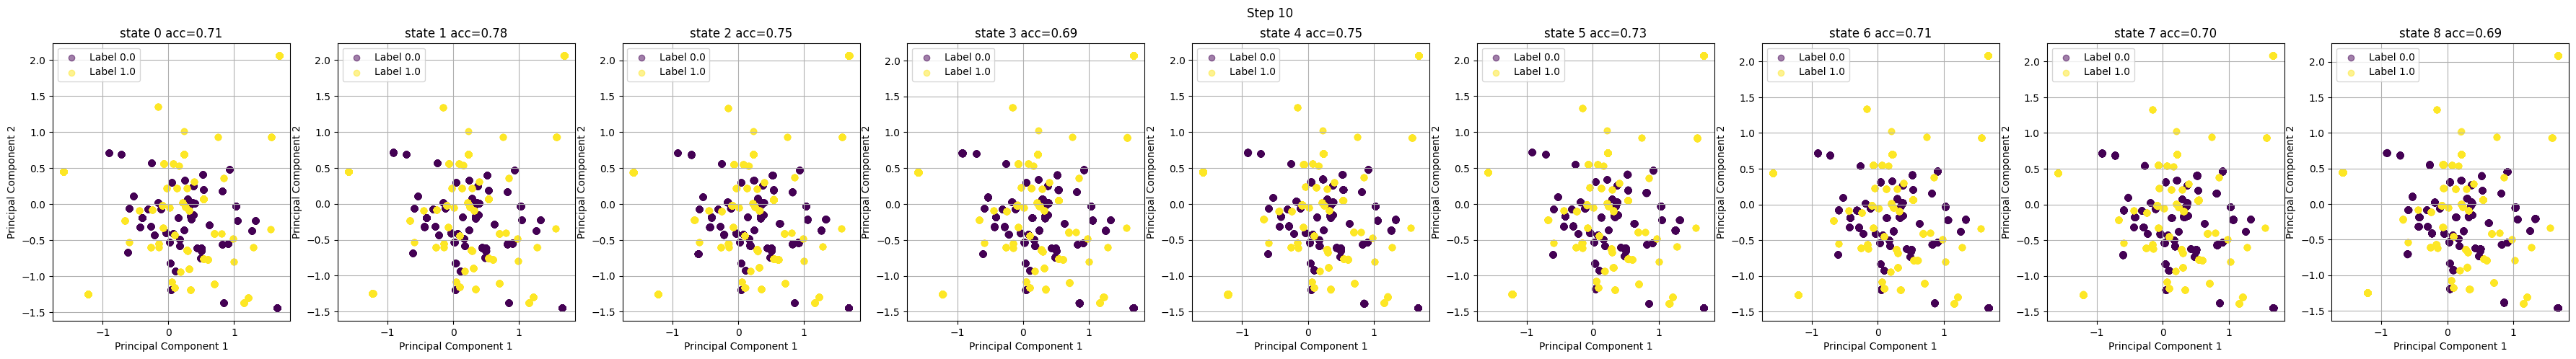

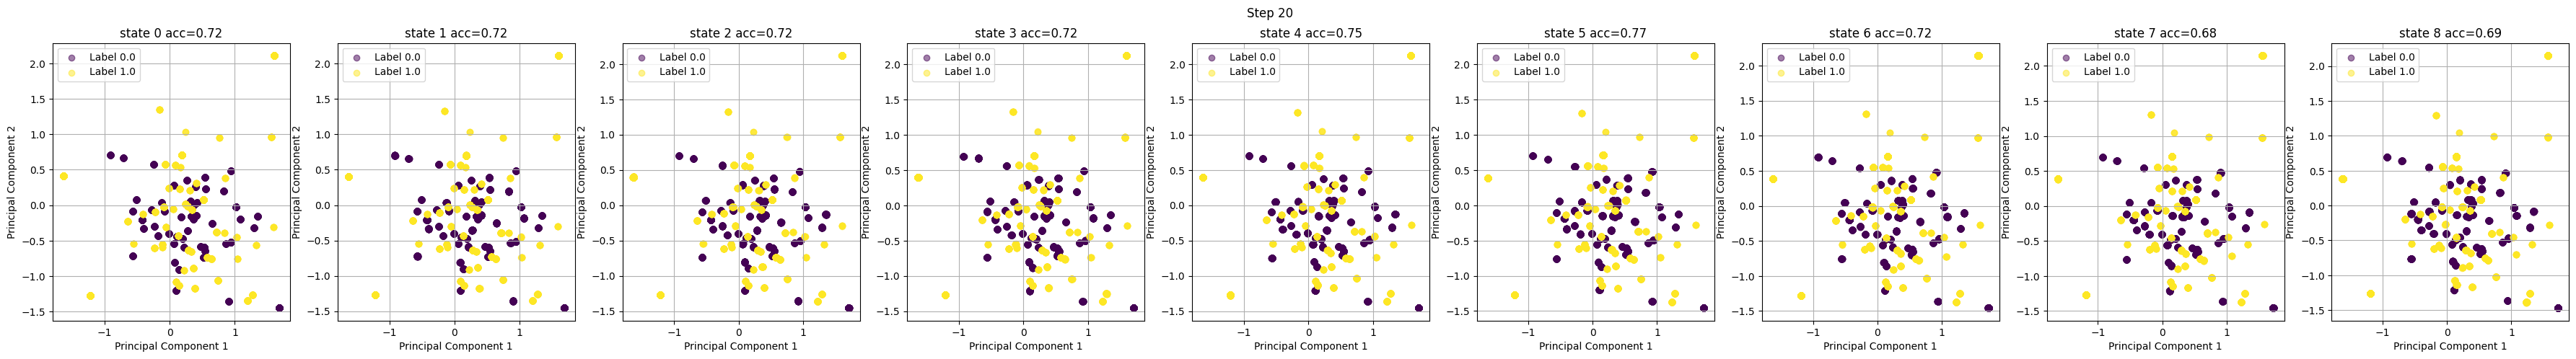

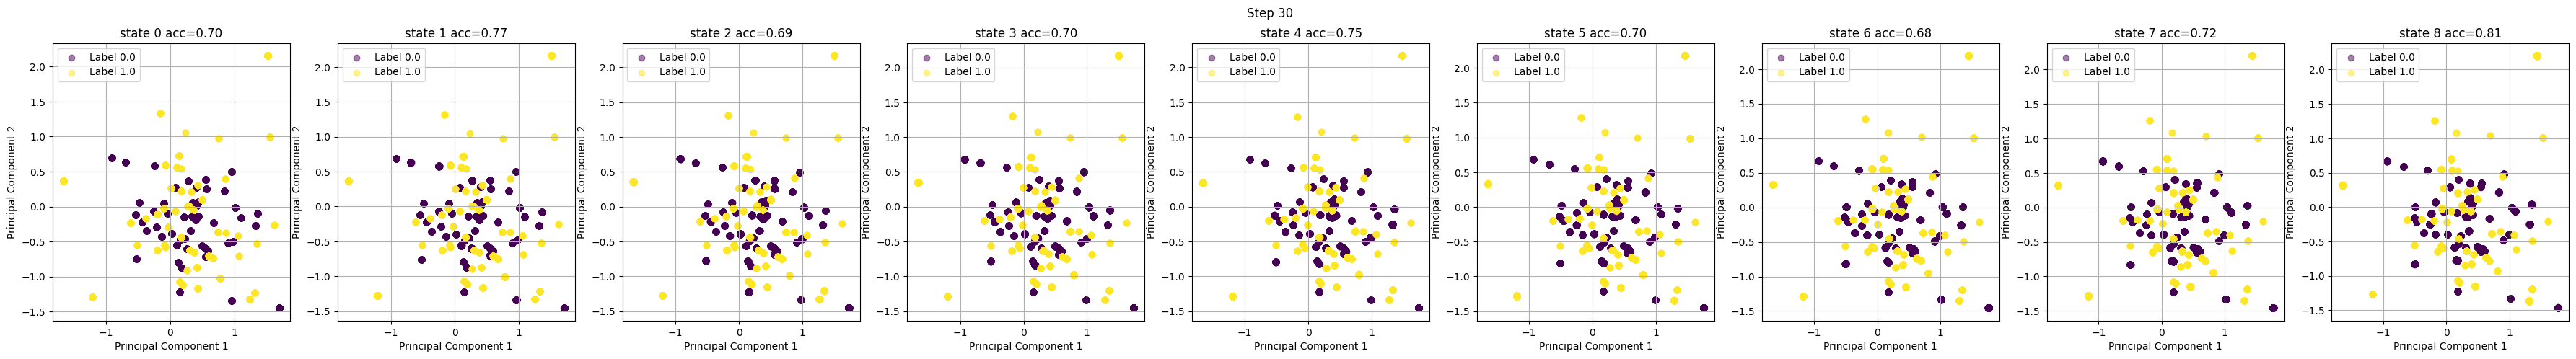

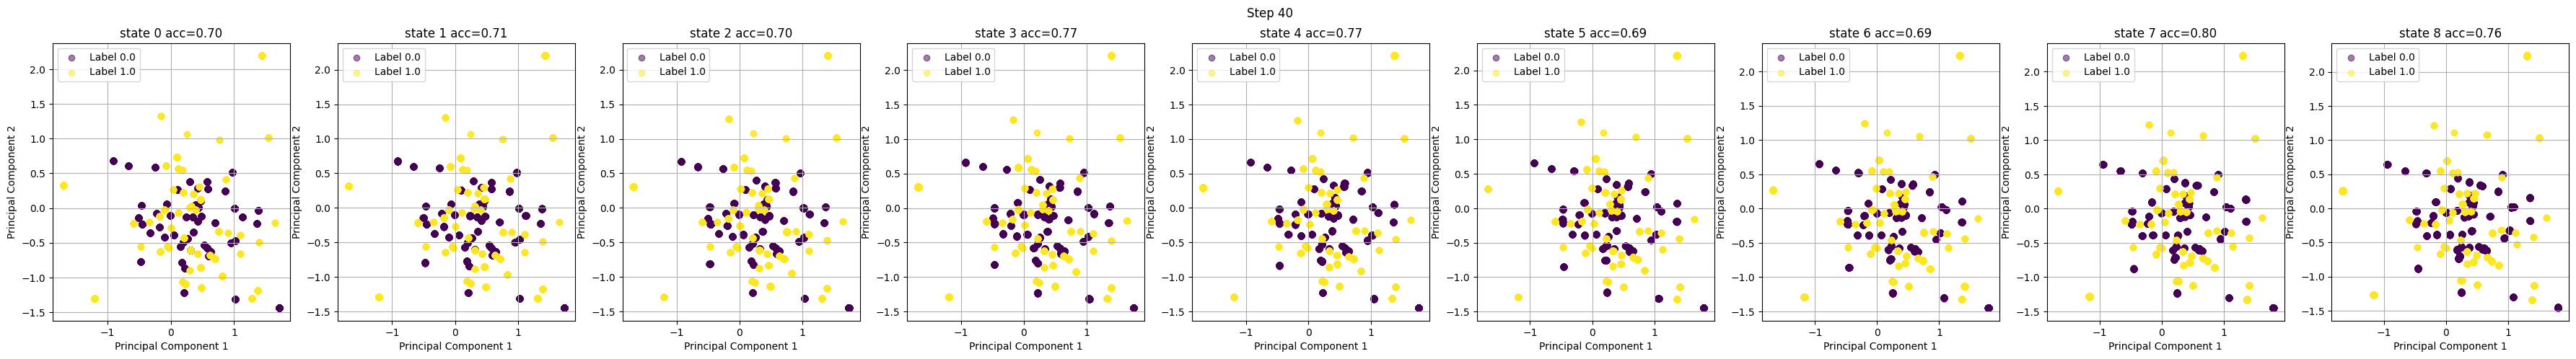

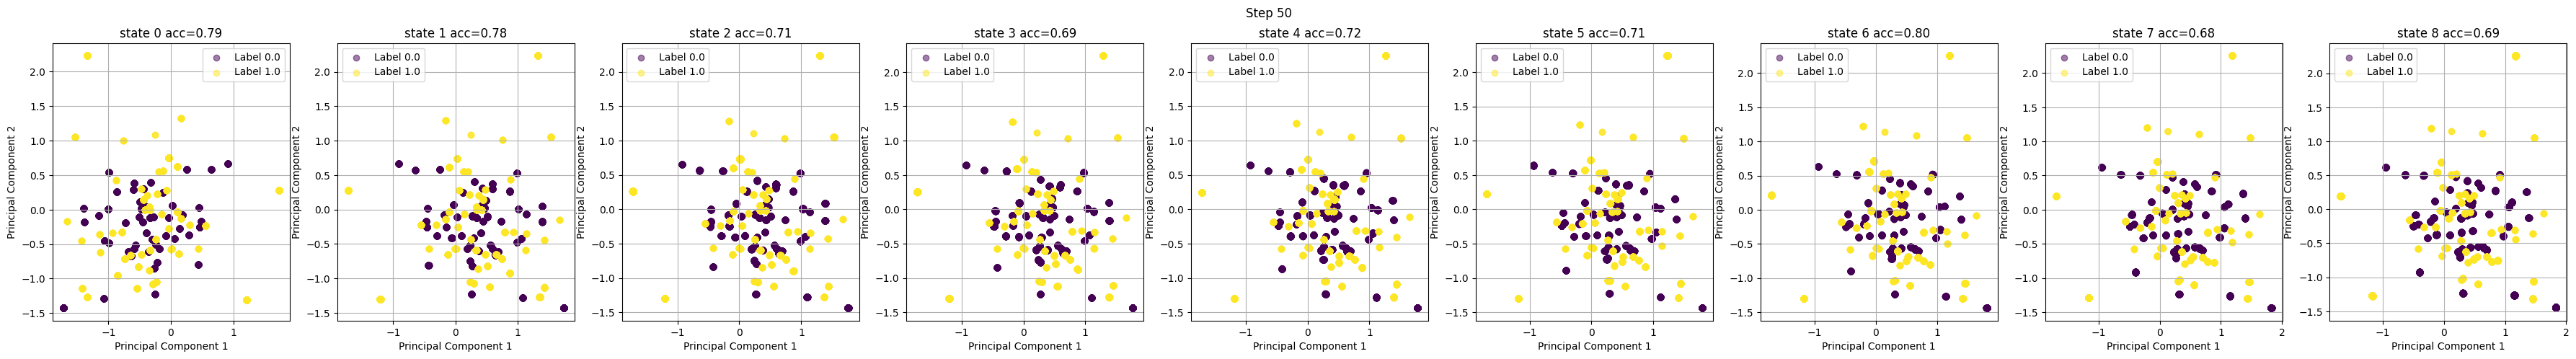

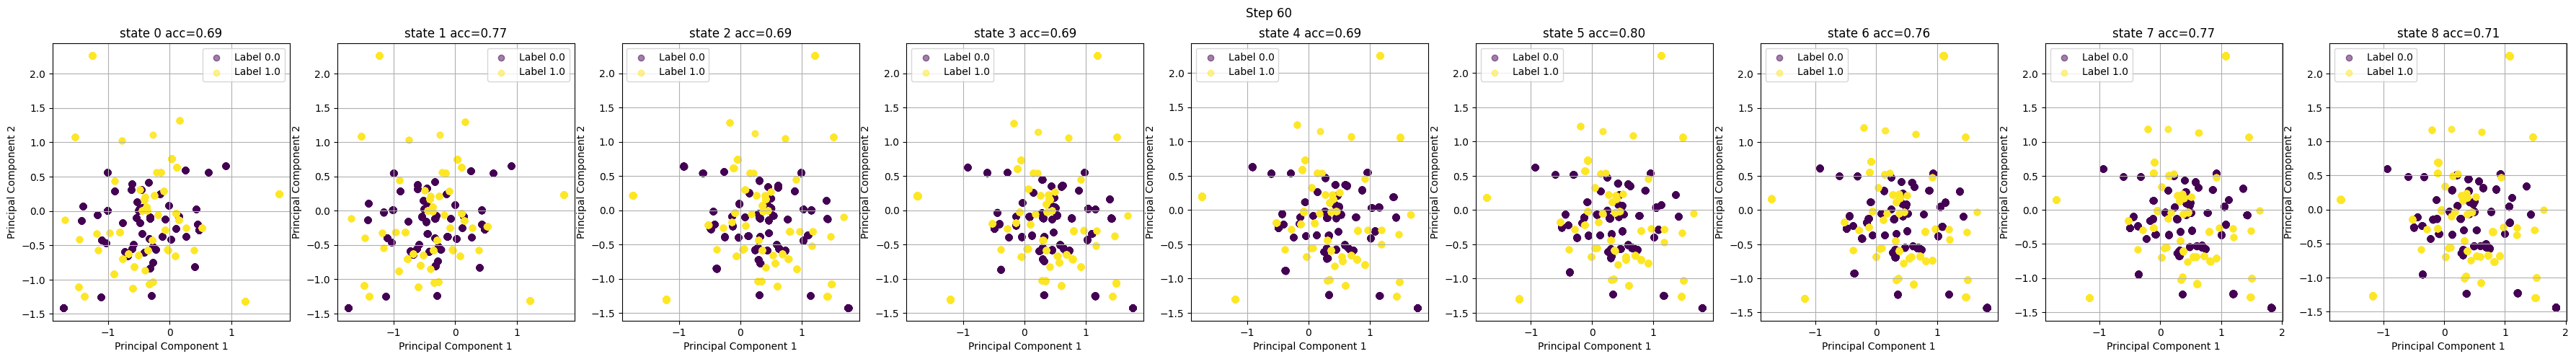

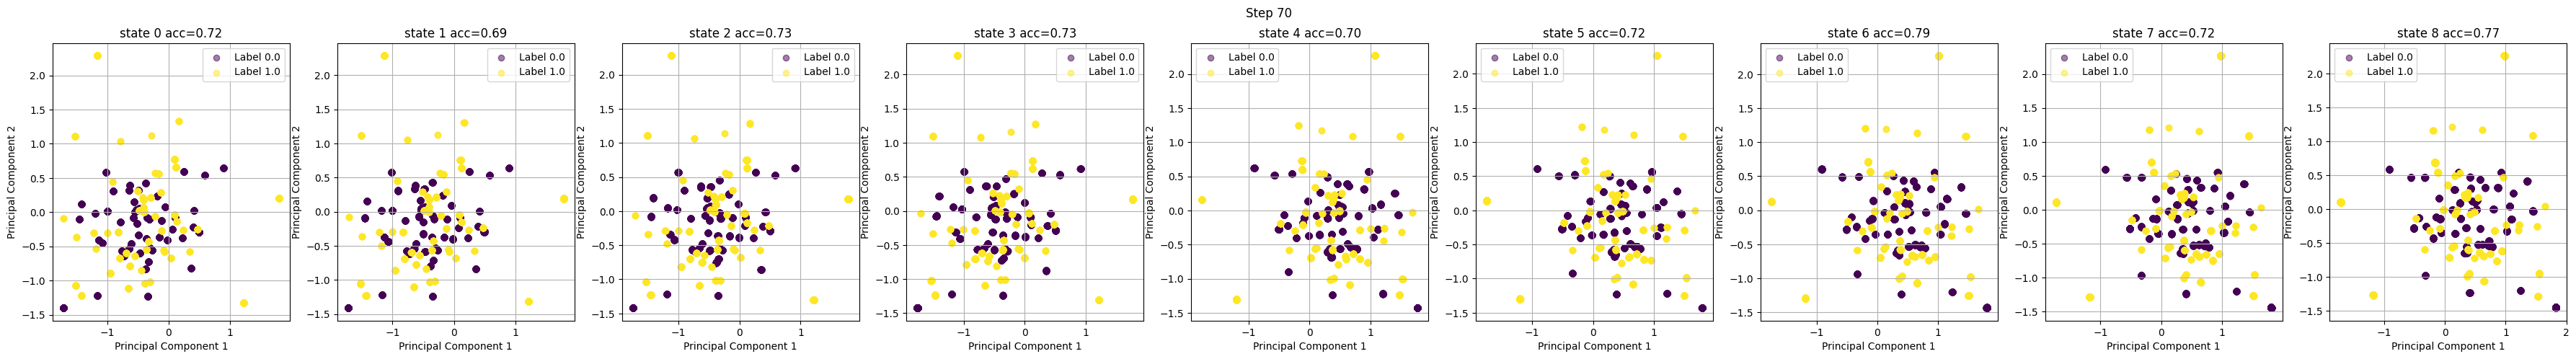

In [18]:
#step_eval = [10, 100, 200, 400, 800, 1000, 2000, 4000, 10000, 38000, 70000]
step_eval = list(range(0, 1000, 10))
hist, probing_results = train_loop(toy_bert_model, train_dataloader, val_dataloader, 
                                   optimizer, num_epochs, 
                                   step_eval=step_eval, name=None)#'pos_model')
val_stats = val_loop(toy_bert_model, val_dataloader)
print(val_stats) # 10 - 80 identical, 10 - 20 1 token 
## make accuracy measurement an all

## pos looks like it is doing alt first actually
## between 4 and 5 epochs looks like strategy changes

In [23]:
df = pd.DataFrame(probing_results)
df = df.transpose()
df.columns = step_eval[:len(df)-2]

df = df[::-1]

In [28]:
pd.DataFrame(hist)

10        20        30        40       50        60        70
acc      0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000
alt_acc  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000
loss     4.593277  4.563362  4.534465  4.507429  4.48288  4.460462  4.440004

In [ ]:
df = pd.DataFrame(probing_results)
df = df.transpose()
df.columns = step_eval[:-1]

df = df[::-1]

ax = sns.heatmap(df, annot=False)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("POS Probing")
plt.savefig('pos_probing_1000steps.png')

plt.show()


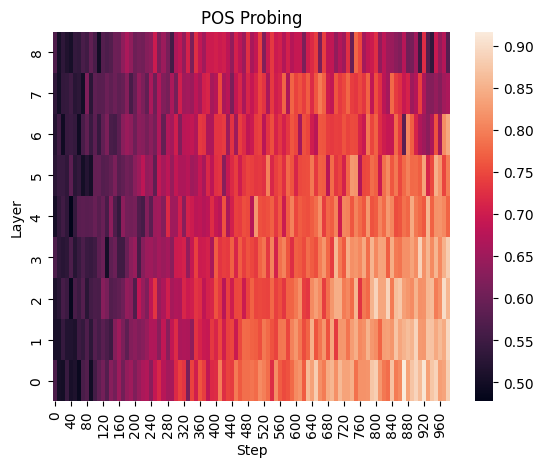

In [66]:
df = pd.DataFrame(probing_results)
df = df.transpose()
df.columns = step_eval[:-1]

df = df[::-1]

ax = sns.heatmap(df, annot=False)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("POS Probing")
plt.savefig('pos_probing_1000steps.png')

plt.show()


In [64]:
def sort_key(filename):
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else 0
    
folder_path = '2-layer/images'
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
image_files.sort(key=sort_key)
fig, axs = plt.subplots(len(image_files), 1, figsize=(10, len(image_files) * 5))

if not isinstance(axs, np.ndarray):
    axs = [axs]

for ax, img_file in zip(axs, image_files):
    img_path = os.path.join(folder_path, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off') 

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '2-layer/images'

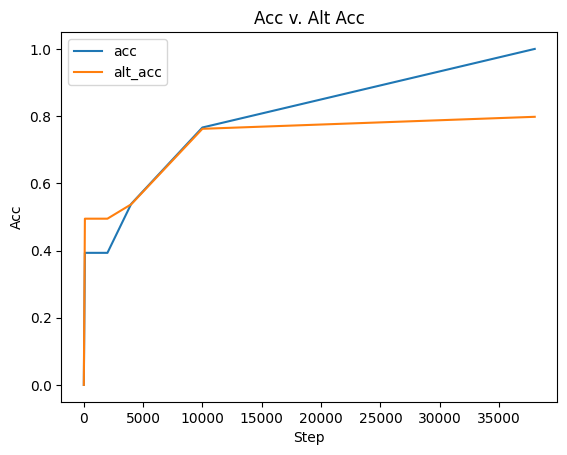

In [44]:
df_hist = pd.DataFrame(hist)
df_hist.transpose().drop('loss', axis=1).plot(kind='line')

plt.xlabel('Step')
plt.ylabel('Acc')
plt.title('Acc v. Alt Acc')
plt.show()


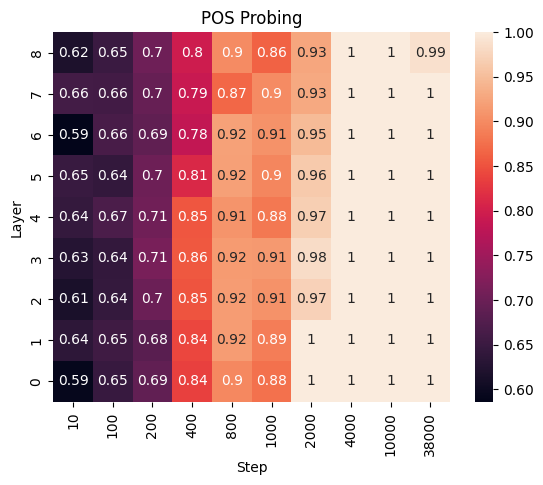

In [45]:
df = pd.DataFrame(probing_results)
df = df.transpose()
df.columns = step_eval[:-1]

df = df[::-1]

ax = sns.heatmap(df, annot=True)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("POS Probing")
plt.savefig('pos_probing.png')

plt.show()


RESULTS 2 LAYER

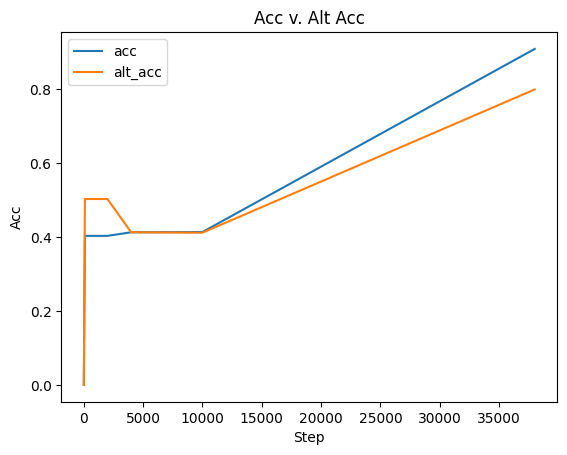

In [22]:
df_hist = pd.DataFrame(hist)
df_hist.transpose().drop('loss', axis=1).plot(kind='line')

plt.xlabel('Step')
plt.ylabel('Acc')
plt.title('Acc v. Alt Acc')
plt.show()


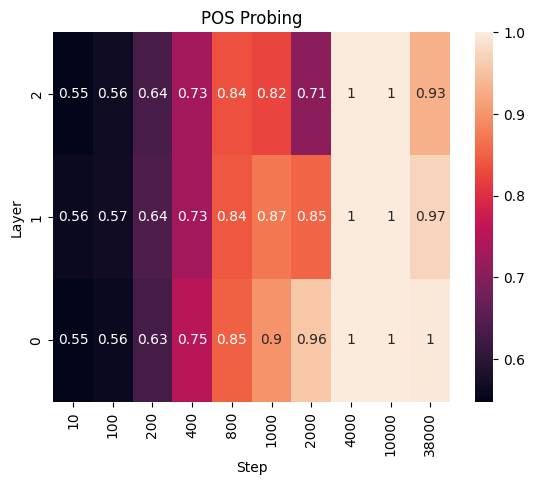

In [27]:
df = pd.DataFrame(probing_results)
df = df.transpose()
df.columns = step_eval[:-1]

df = df[::-1]

ax = sns.heatmap(df, annot=True)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("POS Probing")
plt.savefig('pos_probing.png')

plt.show()


| Metric   | One Hidden Layers | Two Hidden Layers | Three Hidden Layers |
|----------|-------------------|-------------------|---------------------|
| acc      |     0.09462       | 0.09734           | 0.00019             |
| alt_acc  |     0.093527      | 0.09136           | 0.00021             |
| loss     |     0.17726       | 0.07501           | 5.99352             |


In [29]:
# dset = val_dataloader.dataset
# for i in range(100):
#     example, label, alt_label = dset.tensors[0][i], dset.tensors[1][i], dset.tensors[2][i]
#     if not torch.all(label == alt_label):
#         where = (label != -100)
#         print("PREDICTION", toy_bert_model(example.unsqueeze(dim=0)).logits.transpose(1, 2).argmax(axis=1)[where.unsqueeze(0)])
#         print("ALT_LABEL", alt_label[where])
#         print("LABEL", label[where])
#         print()

### DEP Experiment

In [30]:
num_epochs = 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"
task=create_dataset_task_dep

In [31]:
config = BertConfig(
    vocab_size=103 if task==create_dataset_task_pos else 401,
    hidden_size=16, # 128  
    num_hidden_layers=2,  
    num_attention_heads=2, # 8
    intermediate_size=32 # 512
)
toy_bert_model = BertForMaskedLM(config).to(device)
optimizer = torch.optim.AdamW(toy_bert_model.parameters(), lr=5e-5) 
criterion = nn.CrossEntropyLoss()

In [32]:
max_num_steps = 1_000_000 * 5 /128

In [33]:
train_dataloader, val_dataloader = create_dataloaders(1_000_000, 10_000, device=device, task=task)

In [34]:
step_eval = [10, 100, 200, 400, 800, 1000, 2000, 4000, 10000, 38000, 70000]
hist, probing_results = train_loop(toy_bert_model, train_dataloader, val_dataloader, optimizer, num_epochs, step_eval=step_eval, name='dep_model', pca=False)
val_stats = val_loop(toy_bert_model, val_dataloader)
print(val_stats) # 10 - 80 identical, 10 - 20 1 token 
## make accuracy measurement an all

## pos looks like it is doing alt first actually
## between 4 and 5 epochs looks like strategy changes

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

{'acc': 0.5743670886075949, 'alt_acc': 0.5581487341772152, 'loss': 0.8008955264393287}


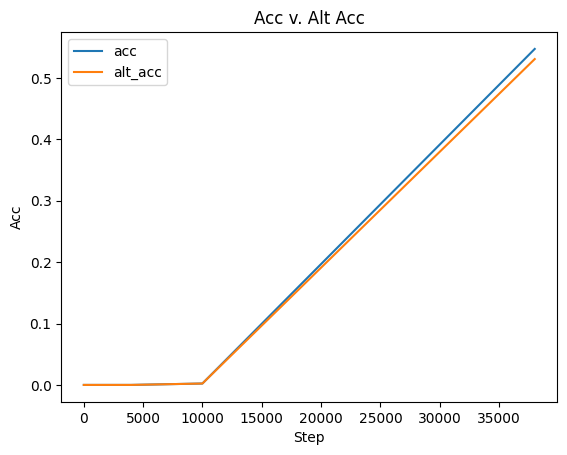

In [35]:
df_hist = pd.DataFrame(hist)
df_hist.transpose().drop('loss', axis=1).plot(kind='line')

plt.xlabel('Step')
plt.ylabel('Acc')
plt.title('Acc v. Alt Acc')
plt.show()

* Trained too few epochs but trend just continues (i.e. never adopts/gets better at alternative strategy)

* Don't know why can't get about 0.429 accuracy
* Tried increasing model width, model num hidden layers, and dataset size
* Alternative strategy accuracy looks better at only very beginning (almost no matter size)

## TOY MODEL

Notes:

1. Residual Connection is not cause
2. Happens with 2 layer (1 interm, head) as well, but separation slightly less present
3. Does not happen when freeze layer 1 in 2 layer (random projection hypothesis)
4. Does not happen when freeze layer 1 in 3 layer (2 interm w/ resid, head) -- figure out why not difference + check layer 2
5. What is happening is not pushback, but rather choosing of a strategy (i.e. fully separable l1 after pt, then simply uses that)

Other Notes:
1. Reducing std hurts, not helps final task (idk why)

In [99]:
class ToyModel(nn.Module):
    def __init__(dset_gen, num_features: int, num_interm : int):
        super().__init__()
        dset_gen.fc1 = nn.Linear(num_features, num_interm)
        # Second fully connected layer
        dset_gen.relu1 = nn.ReLU()
        dset_gen.fc2 = nn.Linear(num_interm, num_interm)
        dset_gen.relu2 = nn.ReLU()
        # dset_gen.fc3 = nn.Linear(num_interm, num_interm)
        # dset_gen.relu3 = nn.ReLU()
        dset_gen.head = nn.Linear(num_interm, 1, bias=False)

    def forward(dset_gen, x):
        if isinstance(x, list):
            x, _ = x
        out = dset_gen.relu1(dset_gen.fc1(x))
        out = dset_gen.relu2(dset_gen.fc2(out)) + out
        # out = dset_gen.relu3(dset_gen.fc3(out)) + out
        return dset_gen.head(out) 

* Train on disambiguated data to detect mean m1
* Train on ambiguated data to detect whole task
* Check whether inetermediate layer data is split by mean m1

### Gen Data Func

In [39]:
## generation hyperparameters

size = 10000
m1, m2, m3, m4 = 0, 0, 2, 3
s1, s2, s3, s4 = 1, 1, 1, 1 ## 1, 1, 1, 1 - dec to 0.2
N, N_p, N_pp = 0, 2, 3
vec_size = 16 ## was 4

heuristic=0.75


In [40]:
def generate_gaussian_inputs(m1, s1, m2, s2, m3, s3, m4, s4, vec_size, N, N_p, N_pp, init_task=True, disamb=0.5, heuristic=None):
    f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
    f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
    f3 = torch.normal(mean=torch.tensor(m3).repeat((1, vec_size)).float(), std=s3)
    f4 = torch.normal(mean=torch.tensor(m4).repeat((1, vec_size)).float(), std=s4)
    f1_gt_N = (torch.mean(f1) > N)
    f2_gt_N = (torch.mean(f2) > N)
    if random.random() < disamb: ## f1 > N != f2 > N (i.e. ambiguous)
        while f1_gt_N == f2_gt_N:
            f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
            f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
    else: ## f1 > N == f2 > N (i.e. ambiguous)
        while f1_gt_N != f2_gt_N:
            f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
            f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
            
    if heuristic is not None:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        if random.random() < heuristic:
            while f1_gt_N != label:
                f3 = torch.normal(mean=torch.tensor(m3).repeat((1, vec_size)).float(), std=s3)
                f4 = torch.normal(mean=torch.tensor(m4).repeat((1, vec_size)).float(), std=s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        else:
            while f1_gt_N == label:
                f3 = torch.normal(mean=torch.tensor(m3).repeat((1, vec_size)).float(), std=s3)
                f4 = torch.normal(mean=torch.tensor(m4).repeat((1, vec_size)).float(), std=s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
                
    full = torch.concat([f1, f2, f3, f4], dim=1) 
    if init_task:
        label = f1_gt_N
        alt_label = f2_gt_N
    else:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        alt_label = (torch.mean(f3) > N_p) if f2_gt_N else (torch.mean(f4) > N_pp) 
    return full, label, alt_label

In [41]:
def mixture(m_a, m_b, s=0.2): 
    if random.random() > 0.5: 
        return torch.normal(mean=torch.tensor(m_a).repeat((1, vec_size)).float(), std=s)
    else: 
        return torch.normal(mean=torch.tensor(m_b).repeat((1, vec_size)).float(), std=s)
        
def generate_gaussian_mixture_inputs_w_heur(m1, s1, m2, s2, m3, s3, m4, s4, vec_size, N, N_p, N_pp, init_task=True, disamb=0.5, heuristic=None):
    f1 = mixture(m1 - 1, m1 + 1, s1)
    f2 = mixture(m2 - 1, m2 + 1, s2)
    f3 = mixture(m3 - 1, m3 + 1, s3)
    f4 = mixture(m4 - 1, m4 + 1, s4)
    f1_gt_N = (torch.mean(f1) > N)
    f2_gt_N = (torch.mean(f2) > N)
    if random.random() < disamb: ## f1 > N != f2 > N (i.e. ambiguous)
        while f1_gt_N == f2_gt_N:
            f1 = mixture(m1 - 1, m1 + 1, s1)
            f2 = mixture(m2 - 1, m2 + 1, s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
    else: ## f1 > N == f2 > N (i.e. ambiguous)
        while f1_gt_N != f2_gt_N:
            f1 = mixture(m1 - 1, m1 + 1, s1)
            f2 = mixture(m2 - 1, m2 + 1, s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
    if heuristic is not None:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        if random.random() < heuristic:
            while f1_gt_N != label:
                f3 = mixture(m3 - 1, m3 + 1, s3)
                f4 = mixture(m4 - 1, m4 + 1, s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        else:
            while f1_gt_N == label:
                f3 = mixture(m3 - 1, m3 + 1, s3)
                f4 = mixture(m4 - 1, m4 + 1, s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
                
    full = torch.concat([f1, f2, f3, f4], dim=1) 
    if init_task:
        label = f1_gt_N
        alt_label = f2_gt_N
    else:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        alt_label = (torch.mean(f3) > N_p) if f2_gt_N else (torch.mean(f4) > N_pp)
    return full, label, alt_label

In [42]:
def create_dataset(init_task, disamb, size=size, heuristic=None):
    inputs = []
    labels = []
    alt_labels = []
    
    for i in tqdm(range(size)):
        input, label, alt_label = generate_gaussian_inputs(m1, s1, m2, s2, m3, s3, m4, s4, 
                                                                          vec_size, N, N_p, N_pp, 
                                                                          init_task=init_task, disamb=disamb, heuristic=heuristic)
        inputs.append(input)
        labels.append(label)
        alt_labels.append(alt_label)
        
    inputs = torch.vstack(inputs)
    labels = torch.vstack(labels).float()
    alt_labels = torch.vstack(alt_labels).float()
    
    train_size = int(0.8 * len(inputs))
    
    inputs_t, labels_t, alt_labels_t = inputs[:train_size], labels[:train_size], alt_labels[:train_size]
    inputs_v, labels_v, alt_labels_v = inputs[train_size:], labels[train_size:], alt_labels[train_size:]

    train_dataset = TensorDataset(inputs_t.detach(), labels_t.view(-1, 1))
    val_dataset = TensorDataset(inputs_v.detach(), labels_v.view(-1, 1))

    train_dataset_alt = TensorDataset(inputs_t.detach(), alt_labels_t.view(-1, 1))
    val_dataset_alt = TensorDataset(inputs_v.detach(), alt_labels_v.view(-1, 1))

    return train_dataset, val_dataset, train_dataset_alt, val_dataset_alt

### Model Params/Functions

In [44]:
## model params/hyperparams

epochs = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
interm_size = 128 ## was 128

In [45]:
def step(model, batch):
    x, y = batch
    logits = model.forward(x)
    loss = F.binary_cross_entropy(torch.sigmoid(logits), y)
    acc = ((logits.squeeze() > 0.5).float() == y.squeeze()).float().mean()
    return loss, {"loss": loss.item(), "acc": acc.item()}

def train_loop(model, train_dataloader, test_dataloader, optimizer, epochs):
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        pbar.set_description(f"Training Epoch {epoch}")
        for batch in train_dataloader:
            model.train()
            optimizer.zero_grad()
            loss, stats = step(model, batch)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(**stats)

        model.eval()
        with torch.no_grad():
            pbar.set_description("Validation")
            for val_batch in test_dataloader:
                loss, stats = step(model, val_batch)
                pbar.set_postfix(**stats)
                
def val_loop(model, test_dataloader):
    model.eval()
    acc, losses = [], []
    with torch.no_grad():
        for val_batch in tqdm(test_dataloader):
            loss, stats = step(model, val_batch)
            acc.append(stats["acc"])
            losses.append(stats["loss"])
    return np.mean(acc), np.mean(losses)

In [46]:
def plot_pcas(interm_train, labels_train, alt_labels_train, title="biased"):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    disamb_learn_numpy = interm_train.detach().numpy()
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(disamb_learn_numpy)
    
    for i, labels_curr in enumerate([labels_train, alt_labels_train]):
        labels_numpy = labels_curr.squeeze()
        unique_labels = np.unique(labels_numpy)
        colors = plt.cm.get_cmap('viridis', len(unique_labels))
        
        for j, label in enumerate(unique_labels):
            axs[i].scatter(data_pca[labels_numpy == label, 0], data_pca[labels_numpy == label, 1], 
                        alpha=0.5, color=colors(j), label=f"Label {label}")
        
        axs[i].set_title(f"Separation of mean(f{i+1}) > N")
        axs[i].set_xlabel("Principal Component 1")
        axs[i].set_ylabel("Principal Component 2")
        axs[i].legend()
        axs[i].grid(True)

    plt.suptitle(title)
    plt.show()

In [47]:
heuristic=None

In [48]:
toy_model = ToyModel(4*vec_size, interm_size)

# for param in toy_model.fc1.parameters():
#     param.requires_grad = False

# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, toy_model.parameters()), lr=0.001)
optimizer = torch.optim.Adam(toy_model.parameters(), lr=0.001)

### Task 1: Learn mean(f1) > N on disambiguated data 

disambiguated = where mean(f2) > N is the same label with p=0.5

In [49]:
def task1(toy_model, optimizer, epochs, heuristic):
    train_dataset, val_dataset, _, _ = create_dataset(init_task=True, disamb=0.5, size=10000, heuristic=heuristic)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

    train_loop(toy_model, train_dataloader, val_dataloader, optimizer, epochs)
    acc, loss = val_loop(toy_model, val_dataloader)
    print(f"ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
    
task1(toy_model, optimizer, epochs, heuristic)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.97, LOSS: 0.05


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_1297575/3323052680.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


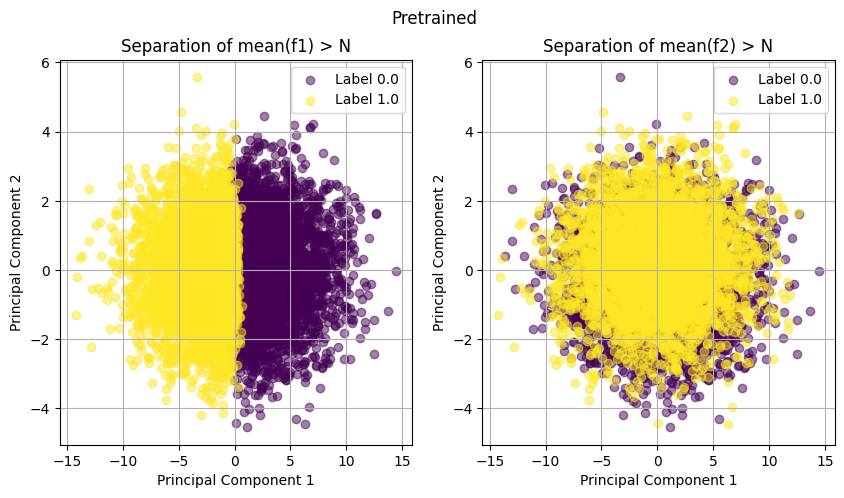

In [50]:
layer1_biased = toy_model.fc1
# layer2_biased = lambda x: toy_model.fc2(toy_model.relu1(toy_model.fc1(x))) + toy_model.fc1(x)

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=0.5)
labels_train, labels_val = train_dataset.tensors[1], val_dataset.tensors[1]
alt_labels_train, alt_labels_val = alt_train_dataset.tensors[1], alt_val_dataset.tensors[1]

# interm_train_biased, interm_val_biased = layer2_biased(train_dataset.tensors[0]), layer2_biased(val_dataset.tensors[0])
# plot_pcas(interm_train_biased, labels_train, alt_labels_train, title="Pretrained")

interm_train_biased, interm_val_biased = layer1_biased(train_dataset.tensors[0]), layer1_biased(val_dataset.tensors[0])
plot_pcas(interm_train_biased, labels_train, alt_labels_train, title="Pretrained")


### Task 2: Learn mean(f3) > N' if mean(f1) > N else mean(f4) > N'' on ambiguated data 

ambiguated = where mean(f2) > N is the same label with p=0.98

In [51]:
for param in toy_model.fc1.parameters():
    param.requires_grad = True

# new_params = [p for p in toy_model.fc1.parameters() if p.requires_grad]
# optimizer.add_param_group({'params': new_params})

In [61]:
toy_model_new = ToyModel(4*vec_size, interm_size) ## ab 75-80% baseline
optimizer_new = torch.optim.Adam(toy_model_new.parameters(), lr=0.001)
epochs=5

In [62]:
def task2(toy_model, optimizer, epochs, heuristic):
    train_dataset, val_dataset, _, _ = create_dataset(init_task=False, disamb=0.50, heuristic=heuristic)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    train_loop(toy_model, train_dataloader, val_dataloader, optimizer, epochs)
    acc, loss = val_loop(toy_model, val_dataloader)
    print(f"ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

task2(toy_model, optimizer, epochs, heuristic)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.81, LOSS: 0.42


In [63]:
task2(toy_model_new, optimizer_new, epochs, heuristic=heuristic)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.74, LOSS: 0.53


### Check: whether intermediate data is better at mean(f1) > N or mean(f2) > N on disambiguated data

In [64]:
train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=False, disamb=1, heuristic=heuristic)

label_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
alt_label_dataloader = DataLoader(alt_val_dataset, batch_size=32, shuffle=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [65]:
acc, loss = val_loop(toy_model, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
acc, loss = val_loop(toy_model, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

  0%|          | 0/63 [00:00<?, ?it/s]

F1 LABELS ACCURACY: 0.81, LOSS: 0.42


  0%|          | 0/63 [00:00<?, ?it/s]

F2 LABELS ACCURACY: 0.43, LOSS: 1.48


In [66]:
acc, loss = val_loop(toy_model_new, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
acc, loss = val_loop(toy_model_new, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

  0%|          | 0/63 [00:00<?, ?it/s]

F1 LABELS ACCURACY: 0.73, LOSS: 0.53


  0%|          | 0/63 [00:00<?, ?it/s]

F2 LABELS ACCURACY: 0.49, LOSS: 1.05


In [25]:
layer1_biased = toy_model.fc1
# layer2_biased = lambda x: toy_model.fc2(toy_model.relu1(toy_model.fc1(x))) + toy_model.fc1(x)
layer1_control = toy_model_new.fc1
# layer2_control = lambda x: toy_model_new.fc2(toy_model_new.relu1(toy_model_new.fc1(x))) + toy_model_new.fc1(x)

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=0.5)
labels_train, labels_val = train_dataset.tensors[1], val_dataset.tensors[1]
alt_labels_train, alt_labels_val = alt_train_dataset.tensors[1], alt_val_dataset.tensors[1]
## need to be ambiguous be maximally random

  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_1297575/3323052680.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


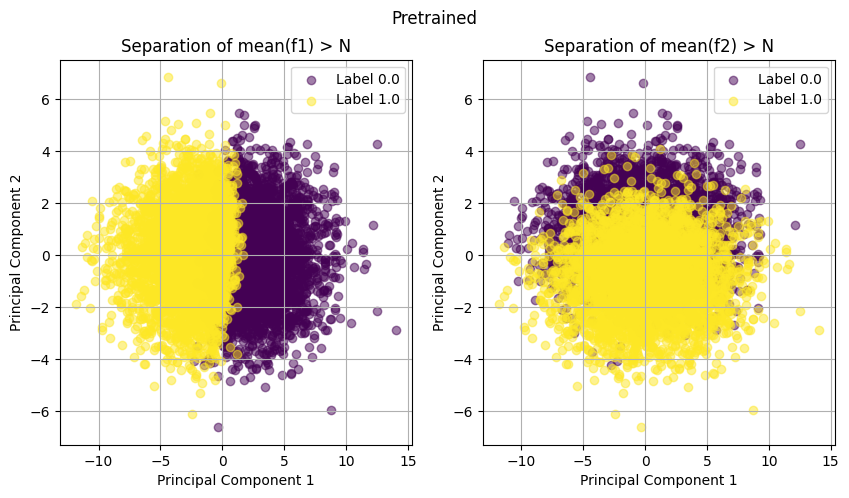

/tmp/ipykernel_1297575/3323052680.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


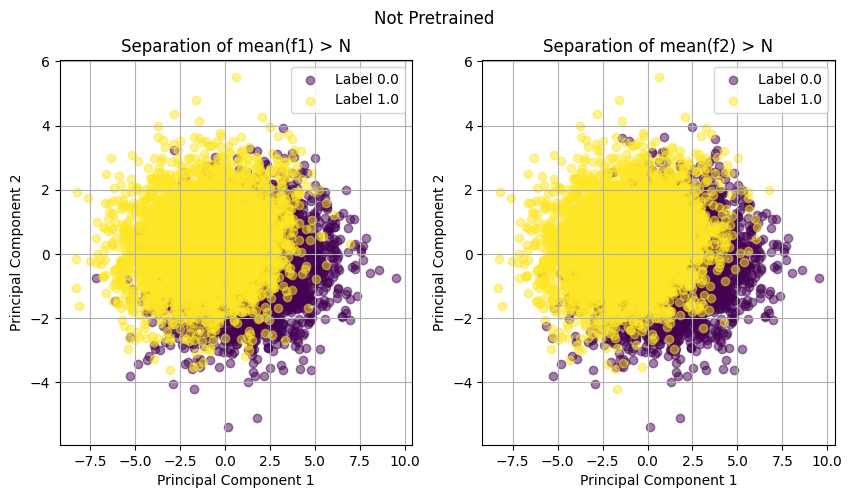

In [26]:
def layer_num_pca(layer_num):
    interm_train_biased, interm_val = eval(f'layer{layer_num}_biased(train_dataset.tensors[0]), layer{layer_num}_biased(val_dataset.tensors[0])')
    plot_pcas(interm_train_biased, labels_train, alt_labels_train, title="Pretrained")

    interm_train_control, interm_val = eval(f'layer{layer_num}_control(train_dataset.tensors[0]), layer{layer_num}_control(val_dataset.tensors[0])')
    plot_pcas(interm_train_control, labels_train, alt_labels_train, title="Not Pretrained")

layer_num_pca(1)

## Covariance Statistics Effect

In [74]:
toy_model_con = ToyModel(6*vec_size, interm_size) ## ab 75-80% baseline
optimizer_con = torch.optim.Adam(toy_model_con.parameters(), lr=0.001)
epochs=6

In [75]:
def task_cov(toy_model, optimizer, epochs, disamb=(0.5, 0.10, 0)):
    train_dataset, val_dataset, _, _ = create_dataset(init_task=False, disamb=disamb, complex=True)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    train_loop(toy_model, train_dataloader, val_dataloader, optimizer, epochs)
    acc, loss = val_loop(toy_model, val_dataloader)
    print(f"ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
task_cov(toy_model_con, optimizer_con, epochs, disamb=(0.5, 0.20, 0))


TypeError: create_dataset() got an unexpected keyword argument 'complex'

In [ ]:
train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=(0.5, 0.2, 0), complex=True)
label_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
alt_label_dataloader = DataLoader(alt_val_dataset, batch_size=32, shuffle=False)

acc, loss = val_loop(toy_model_cov, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

acc, loss = val_loop(toy_model_cov, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")


In [100]:
toy_model_cov = ToyModel(6*vec_size, interm_size) ## ab 75-80% baseline
optimizer_cov = torch.optim.Adam(toy_model_cov.parameters(), lr=0.001)

In [104]:
task_cov(toy_model_con, optimizer_con, epochs, disamb=(0.5, 0.20, 0))

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=False, disamb=(0.5, 0.2, 1), complex=True)
label_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
alt_label_dataloader = DataLoader(alt_val_dataset, batch_size=32, shuffle=False)

acc, loss = val_loop(toy_model_cov, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

acc, loss = val_loop(toy_model_cov, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.91, LOSS: 0.23


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

F1 LABELS ACCURACY: 0.46, LOSS: 0.79


  0%|          | 0/63 [00:00<?, ?it/s]

F2 LABELS ACCURACY: 0.54, LOSS: 0.72


In [ ]:
layer1_biased = toy_model_cov.fc1
layer2_biased = lambda x: toy_model.fc2(toy_model.relu1(toy_model.fc1(x))) + toy_model.fc1(x)
layer1_control = toy_model_new.fc1
layer2_control = lambda x: toy_model_new.fc2(toy_model_new.relu1(toy_model_new.fc1(x))) + toy_model_new.fc1(x)

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=0.5)
labels_train, labels_val = train_dataset.tensors[1], val_dataset.tensors[1]
alt_labels_train, alt_labels_val = alt_train_dataset.tensors[1], alt_val_dataset.tensors[1]

In [ ]:
layer_num_pca(1)

In [24]:
import scipy

scipy.stats.pearsonr(labels_train.squeeze(), alt_labels_train.squeeze()) 
## uncorrelated

PearsonRResult(statistic=-0.0030117006610420635, pvalue=0.7876732749754165)

In [139]:
disamb_learn_numpy.shape

(8000, 128)

In [140]:
labels_train.shape

torch.Size([8000, 1])

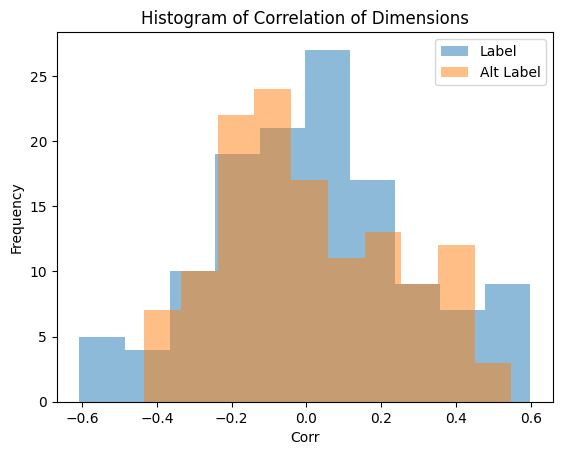

Max Corr Label 0.5988681562903855 , Max Corr Alt Label 0.5482244454480574

Top 10 Corr Label [0.59886816 0.55941821 0.55115218 0.54402599 0.5433952  0.52871933
 0.52069526 0.51768924 0.48808707 0.46045053] 
Top 10 Corr Alt Label [0.54822445 0.47418461 0.46007081 0.43732092 0.42496988 0.41557385
 0.40782031 0.40142805 0.39683998 0.39470528]


In [141]:
corr_label_dims = [scipy.stats.pearsonr(labels_train.squeeze(), interm_train.detach()[:, i]).statistic for i in range(interm_train.shape[1])]
corr_alt_label_dims = [scipy.stats.pearsonr(alt_labels_train.squeeze(), interm_train.detach()[:, i]).statistic for i in range(interm_train.shape[1])]

plt.hist(corr_label_dims, alpha=0.5, label='List 1')
plt.hist(corr_alt_label_dims, alpha=0.5, label='List 2')
plt.title('Histogram of Correlation of Dimensions')
plt.xlabel('Corr')
plt.ylabel('Frequency')
plt.legend(['Label', 'Alt Label'])

plt.show()

print('Max Corr Label', max(corr_label_dims), ', Max Corr Alt Label', max(corr_alt_label_dims))
print('\nTop 10 Corr Label', torch.topk(torch.tensor(corr_label_dims), 10).values.numpy(), '\nTop 10 Corr Alt Label', torch.topk(torch.tensor(corr_alt_label_dims), 10).values.numpy())

Have some higher frequency of correlation, which is important/shows some difference potentially

In [143]:
train_size = int(0.8 * len(interm_train))

train_dataset = TensorDataset(interm_train.detach(), labels_train.view(-1, 1))
val_dataset = TensorDataset(interm_val.detach(), labels_val.view(-1, 1))

train_dataset_alt = TensorDataset(interm_train.detach(), alt_labels_train.view(-1, 1))
val_dataset_alt = TensorDataset(interm_val.detach(), alt_labels_val.view(-1, 1))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_dataloader_alt = DataLoader(train_dataset_alt, batch_size=32, shuffle=True)
val_dataloader_alt = DataLoader(val_dataset_alt, batch_size=32, shuffle=False)

probe_labels = Probe(interm_train.shape[1]).to(device)
probe_alt_labels = Probe(interm_train.shape[1]).to(device)

In [146]:
trainer = Trainer(max_epochs=epochs)
trainer.fit(probe_labels, train_dataloader, val_dataloader)
trainer.validate(probe_labels, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | body | Linear | 128   
--------------------------------
128       Trainable params
0         Non-trainable params
128       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9664999842643738     │
│      val_loss_epoch       │    0.05521305650472641    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.05521305650472641, 'val_acc_epoch': 0.9664999842643738}]

In [147]:
trainer = Trainer(max_epochs=1)
trainer.fit(probe_alt_labels, train_dataloader_alt, val_dataloader_alt)
trainer.validate(probe_alt_labels, val_dataloader_alt)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | body | Linear | 128   
--------------------------------
128       Trainable params
0         Non-trainable params
128       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9564999938011169     │
│      val_loss_epoch       │    0.0874154269695282     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.0874154269695282, 'val_acc_epoch': 0.9564999938011169}]

## TRANSPLANTATION

In [ ]:
PYTHIA_VOCAB_SIZE = 50277 #50304
N_LAYERS=12
MODEL = "EleutherAI/pythia-160m"
PYTHIA_CHECKPOINTS_OLD = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512] + list(range(1000, 143000 + 1, 10000)) + [143000]
PYTHIA_CHECKPOINTS = [512] + list(range(1000, 10000 + 1, 1000))

HeadName = Literal["previous_token_head", "duplicate_token_head", "induction_head"]
HEAD_NAMES = cast(List[HeadName], get_args(HeadName))

In [ ]:
def create_repeats_dataset(num_samples=50, min_vector_size=5, max_vector_size=50, min_num_repeats=5, max_num_repeats=20, max_vocab=PYTHIA_VOCAB_SIZE):
  """Creates a dataset for the experiment."""
  dataset = []
  for _ in range(num_samples):
    vector_size = torch.randint(min_vector_size, max_vector_size, (1,)).item()
    num_repeats = torch.randint(min_num_repeats, max_num_repeats, (1,)).item()
    tokens = torch.randint(0, max_vocab, (1, vector_size))
    tokens = tokens.repeat((1, num_repeats))
    dataset.append(tokens)
  return dataset

In [ ]:
dataset = torch.load('../outputs/aheads/dataset.pt')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def copy_attention_head(model1, model2, layer_idx, head_idx, dataset):
  if model1.isinstance(HookedTransformer) and model2.isinstance(HookedTransformer):
    model1.W_K.data[layer_idx, head_idx, :, :] = model2.W_K.data[layer_idx, head_idx, :, :]
    model1.W_Q.data[layer_idx, head_idx, :, :] = model2.W_Q.data[layer_idx, head_idx, :, :]
    model1.W_V.data[layer_idx, head_idx, :, :] = model2.W_V.data[layer_idx, head_idx, :, :]
    model1.b_K.data[layer_idx, head_idx, :] = model2.b_K.data[layer_idx, head_idx, :]
    model1.b_Q.data[layer_idx, head_idx, :] = model2.b_Q.data[layer_idx, head_idx, :]
    model1.b_V.data[layer_idx, head_idx, :] = model2.b_V.data[layer_idx, head_idx, :]
  else:
    model1.encoder.layers[layer_idx].dset_gen_attn.in_proj_weight.data[head_idx,:,:] = model2.encoder.layers[layer_idx].dset_gen_attn.in_proj_weight.data[head_idx,:,:]
  return perplexity(model1, dataset), perplexity(model2, dataset)


In [13]:
def calculate_perplexity(corpus, model, device="cpu"):
    encoded_input = model.to_tokens(corpus)
    encoded_input = encoded_input.to(device)
    with torch.no_grad():
      outputs = model(encoded_input).squeeze(0)
      loss = F.cross_entropy(outputs, encoded_input.squeeze(0), reduction='sum')/encoded_input.shape[1]
    perplexity = torch.exp(loss).item()
    return perplexity

In [15]:
def perplexity(model, dataset):
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
  with torch.no_grad():
    for batch in data_loader:
      inputs, targets = batch
      outputs = model(inputs)
      loss = F.cross_entropy(outputs, targets, reduction='sum')
      total_loss += loss.item()
    average_loss = total_loss / len(data_loader.dataset)
    return torch.exp(torch.tensor(average_loss))

# Attn Head Figure Gen

In [224]:
import pandas as pd
import seaborn as sns

In [242]:
home = os.environ['LEARNING_DYNAMICS_HOME']

In [290]:
def make_line_graph(folder_path, layer, task, output_file):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    nrows = len(csv_files) // 3 + (len(csv_files) % 3 > 0)
    ncols = 3
    
    plt.figure(figsize=(10, 6))

    outputs = []
    for i, file in enumerate(csv_files):
        df = pd.read_csv(os.path.join(folder_path, file), delimiter='\t').drop('Layer', axis=1)
        df = df[['20', '40', '60', '80', '100', '200', '1000', '1400', '1600',
       '1800', '2000']]
        df.index = df.index[::-1]
        if 'head' in file:
            head = file.split('head_')[-1].split('.csv')[0]
            outputs.append((head, df.loc[layer].tolist()))  
            plt.plot(df.columns,  df.loc[layer].tolist(), label=f'Head {head}')
            
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.title(f'{task} - Attention Layer {layer}')
    plt.xlabel('Timestep')
    plt.ylabel('Accuracy')
    legend = plt.legend(title='Legend', title_fontsize='13', fontsize='10', loc='best')

    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(1.5)
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()
    return outputs, df.columns

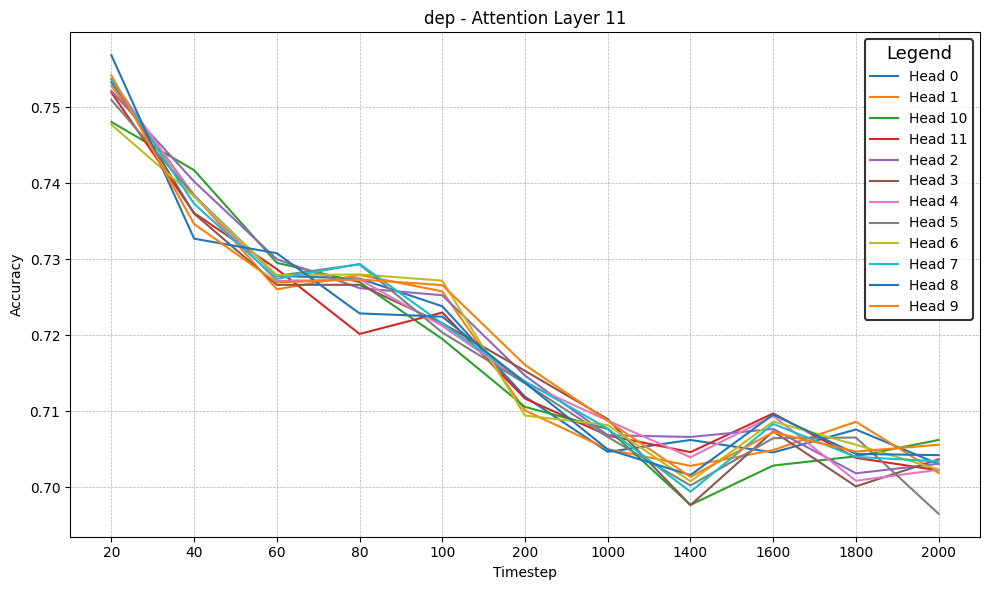

In [291]:

_ = make_line_graph(os.path.join(home, 'outputs/en_ewt-ud/dep/components'), 11, 'dep', os.path.join(home, 'figures/dep_11_heads.png'))

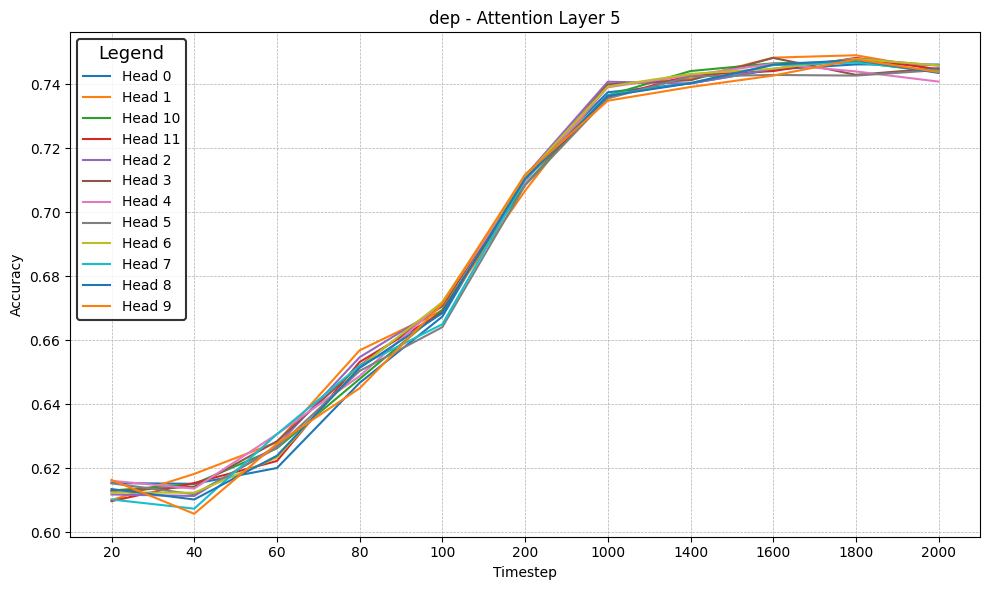

In [292]:
_ = make_line_graph(os.path.join(home, 'outputs/en_ewt-ud/dep/components'), 5, 'dep', os.path.join(home, 'figures/dep_5_heads.png'))

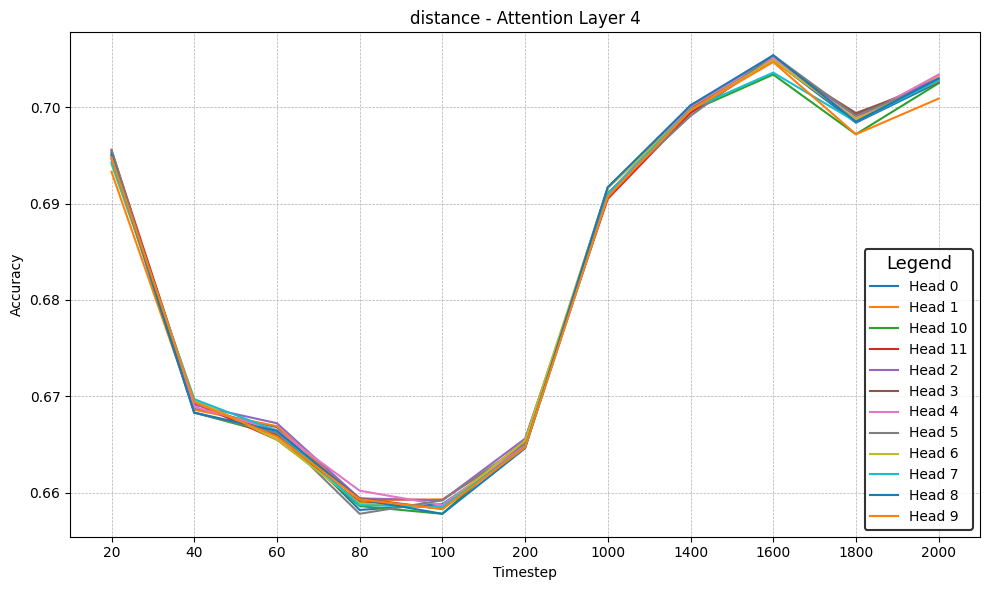

In [310]:
_ = make_line_graph(os.path.join(home, 'outputs/ptb_3/distance/components/DSpr'), 4, 'distance', os.path.join(home, 'figures/head_examples/distance_5_heads.png'))